# **Otimização - Toy Experiment: Mitigação de Crosstalk**
## **Notebook de Otimização**

**Disciplina:** PPGEE0016 - Otimização

**Alunos:** André Paiva, Josias Souza, Victor Emanuel Paz

In [1]:
import sys
sys.path.insert(1, "../crosstalk/")

from time import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from functions import *
from XTconstants import *

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
# Setting a random seed for reproducibility. Using a fixed seed value (5) ensures that the random numbers generated
# are the same across different runs of the code. This is important for verifying results, as it allows
# for consistent experimentation and comparison of outcomes.
np.random.seed(5)

In [ ]:
df = pd.read_csv("./dataset/data.csv", index_col=0)
df

In [4]:
def func_s(params, n, sampling_period=25):
    """
    Aproxima uma amostra do sinal contaminado por crosstalk.
    
    Parâmetros:
      params: dicionário contendo E, tau, E_x, tau_x e sample_delay.
      n: índice da amostra.
      sampling_period: intervalo entre amostras (padrão 25 ns).
      
    Retorna:
      Valor da amostra aproximada de acordo com os parâmetros.
    """
    # Aqui se assume que cellFunction e XTalk já estão definidas.
    clean_signal = params["E"] * cellFunction(sampling_period*(n+1)*46.74/params["tau"] + params["sample_delay"])
    xt_signal = params["E_x"] * XTalk(sampling_period*(n+1)*32.16/params["tau_x"] + params["sample_delay"])
    return clean_signal + xt_signal

In [5]:
def func_mse(samples, params, sampling_period=25):
    mse = 0
    for i in range(samples.shape[0]):
        mse += (samples[i] - func_s(params, i, sampling_period))**2
    mse /= samples.shape[0]
    return mse

In [6]:
def genetico(samples, funcao=func_mse, sampling_period=25, populacao=100, iteracoes=100, p_recomb=0.15, p_mutacao=0.05):
    # Inicialização da população
    E_init = np.abs(np.random.normal(loc=90000, scale=80000, size=populacao))
    tau_init = np.abs(np.random.normal(loc=60, scale=10, size=populacao))
    E_x_init = np.abs(np.random.normal(loc=9000, scale=8000, size=populacao))
    tau_x_init = np.abs(np.random.normal(loc=60, scale=10, size=populacao))
    samp_delay_init = np.abs(np.random.normal(loc=3, scale=4, size=populacao))
    x_matrix = np.stack([E_init, tau_init, E_x_init, tau_x_init, samp_delay_init], axis=1)
    
    avg_fitness = np.array([])
    min_fitness = np.array([])
    col = ['E', 'tau', 'E_x', 'tau_x', 'sample_delay', 'fitness', 'iter']
    df_evolution = pd.DataFrame(columns=col)
    
    x_pop = np.copy(x_matrix)
    time_init = time()
    best = {"E": -np.inf, "tau": -np.inf, "E_x": -np.inf, "tau_x": -np.inf, "sample_delay": -np.inf}
    
    for i in range(iteracoes):
        # Avaliação da população
        x_params = [{"E": candidato[0],
                     "tau": candidato[1],
                     "E_x": candidato[2],
                     "tau_x": candidato[3],
                     "sample_delay": candidato[4]} for candidato in x_pop]
        x_fitness = np.array([-funcao(samples, params, sampling_period) for params in x_params]).reshape(-1, 1)
        iter_atual = np.tile([i], x_pop.shape[0]).reshape(-1, 1)
        df_data = np.concatenate((x_pop, x_fitness, iter_atual), axis=1)
        df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)
        
        # Salvando as métricas de fitness
        avg_fitness = np.append(avg_fitness, np.mean(x_fitness))
        min_fitness = np.append(min_fitness, np.min(x_fitness))
        
        # Ordenação da população (fitness crescente)
        x_sort = np.argsort(x_fitness, axis=0).reshape(-1)
        x_fitness = x_fitness[x_sort]
        x_pop = x_pop[x_sort]
        best = {"E": x_pop[-1, 0],
                "tau": x_pop[-1, 1],
                "E_x": x_pop[-1, 2],
                "tau_x": x_pop[-1, 3],
                "sample_delay": x_pop[-1, 4]}
        
        # Probabilidade de seleção
        prob_num = np.array([np.sum(np.arange(1, i+1)) for i in range(1, x_pop.shape[0]+1)])
        prob_den = np.sum(np.arange(1, x_pop.shape[0]+1))
        prob = prob_num / prob_den
        
        # Seleção
        selecao_prob = np.random.rand(np.ceil(x_pop.shape[0]/2).astype(np.int32), 2)
        index_selecao_prob = np.searchsorted(prob, selecao_prob, side='right')
        
        # Recombinação
        new_pop = np.empty((0, x_pop.shape[1]))
        for j in index_selecao_prob:
            candidato1 = x_pop[j[0]]
            candidato2 = x_pop[j[1]]
            recomb_mask = np.random.rand(candidato1.shape[0]) <= p_recomb
            novo_candidato1 = np.where(recomb_mask, candidato2, candidato1).reshape((1, -1))
            novo_candidato2 = np.where(recomb_mask, candidato1, candidato2).reshape((1, -1))
            new_pop = np.concatenate((new_pop, novo_candidato1, novo_candidato2), axis=0)
        new_pop = new_pop[:x_pop.shape[0]]
        
        # Mutação
        E_init = np.abs(np.random.normal(loc=90000, scale=80000, size=populacao))
        tau_init = np.abs(np.random.normal(loc=60, scale=10, size=populacao))
        E_x_init = np.abs(np.random.normal(loc=9000, scale=8000, size=populacao))
        tau_x_init = np.abs(np.random.normal(loc=60, scale=10, size=populacao))
        samp_delay_init = np.abs(np.random.normal(loc=3, scale=4, size=populacao))
        mut_gen = np.stack([E_init, tau_init, E_x_init, tau_x_init, samp_delay_init], axis=1)
        mut_mask = np.random.rand(new_pop.shape[0], new_pop.shape[1]) <= p_mutacao
        new_pop = np.where(mut_mask, mut_gen, new_pop)
        
        # Atualiza população
        x_pop = np.copy(new_pop)
        
        # Última avaliação (se for a última iteração)
        if i == iteracoes - 1:
            x_params = [{"E": candidato[0],
                         "tau": candidato[1],
                         "E_x": candidato[2],
                         "tau_x": candidato[3],
                         "sample_delay": candidato[4]} for candidato in x_pop]
            x_fitness = np.array([-funcao(samples, params, sampling_period) for params in x_params]).reshape(-1, 1)
            iter_atual = np.tile([i], x_pop.shape[0]).reshape(-1, 1)
            df_data = np.concatenate((x_pop, x_fitness, iter_atual), axis=1)
            df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)
            avg_fitness = np.append(avg_fitness, np.mean(x_fitness))
            min_fitness = np.append(min_fitness, np.min(x_fitness))
    
    elapsed_time = (time() - time_init) * 1000  # tempo em milissegundos
    fitness_metrics = np.concatenate((avg_fitness.reshape(-1,1), min_fitness.reshape(-1,1)), axis=1)
    df_fitness = pd.DataFrame(fitness_metrics, columns=["avg_fitness", "min_fitness"])
    
    return best, df_evolution, df_fitness, elapsed_time

In [7]:
signal_index = np.random.randint(0, 99)
samples = np.array([df[f"S_{i}"][signal_index] for i in range(1, 5)])
best, df_evolution, df_fitness, elapsed_time = genetico(samples)

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\106432779.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


In [8]:
df_est_comparison = pd.DataFrame(data=[["E", best["E"], df["E"][signal_index]],
                                 ["Tau", best["tau"], df["tau"][signal_index]],
                                 ["E_x", best["E_x"], df["E_x"][signal_index]],
                                 ["Tau_x", best["tau_x"], df["tau_x"][signal_index]],
                                 ["Sampling Delay", best["sample_delay"], df["delay_sampling"][signal_index]]],
                                 columns=["Parâmetro", "Estimado", "Esperado"])

df_est_comparison

Parâmetro      Estimado      Esperado
0               E  49248.221103  66415.077374
1             Tau     45.348043     48.810000
2             E_x  17167.603477   4249.817316
3           Tau_x     74.005129     19.260000
4  Sampling Delay      7.991451      6.027536

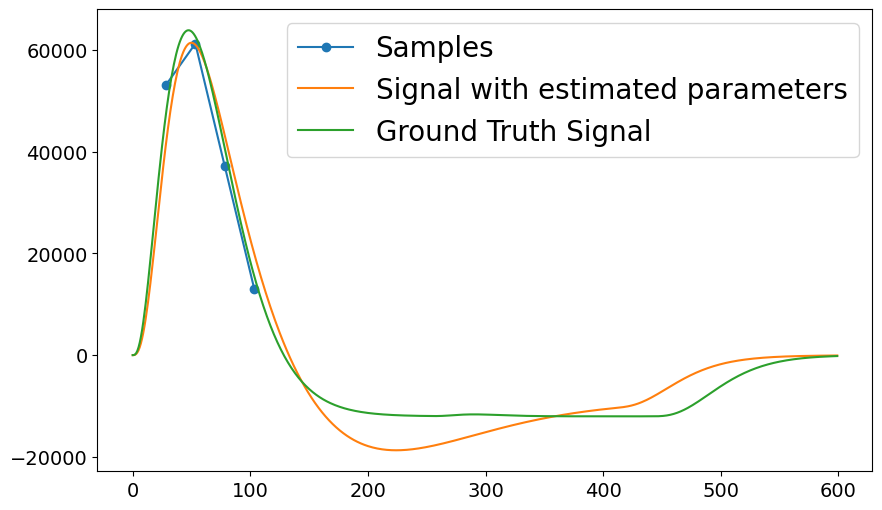

In [9]:
plt.plot([df["delay_sampling"][0] + 25,
          df["delay_sampling"][0] + 50,
          df["delay_sampling"][0] + 75,
          df["delay_sampling"][0] + 100], samples, marker='o', label="Samples")

ETrue_est = np.array([best["E"]*cellFunction(t*46.74/best["tau"]) for t in range(600)])
XT_est = np.array([best["E_x"]*XTalk(t*32.16/best["tau_x"]) for t in range(600)])
signal_est = ETrue_est + XT_est

ETrue_gt = np.array([df["E"][signal_index]*cellFunction(t*46.74/df["tau"][signal_index]) for t in range(600)])
XT_gt = np.array([df["E_x"][signal_index]*XTalk(t*32.16/df["tau_x"][signal_index]) for t in range(600)])
signal_gt = ETrue_gt + XT_gt

#Gráfico Comparativo
plt.plot(range(600), signal_est, label="Signal with estimated parameters")
plt.plot(range(600), signal_gt, label="Ground Truth Signal")
plt.legend()
plt.show()


C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


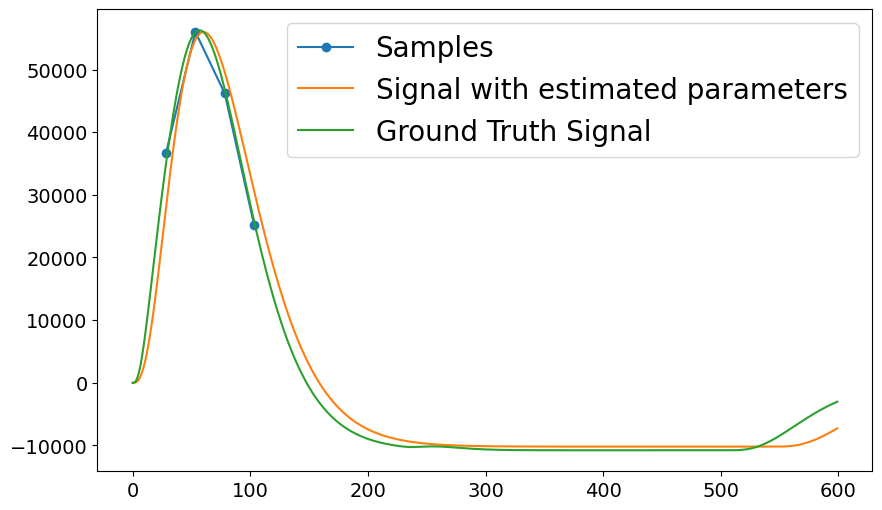

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


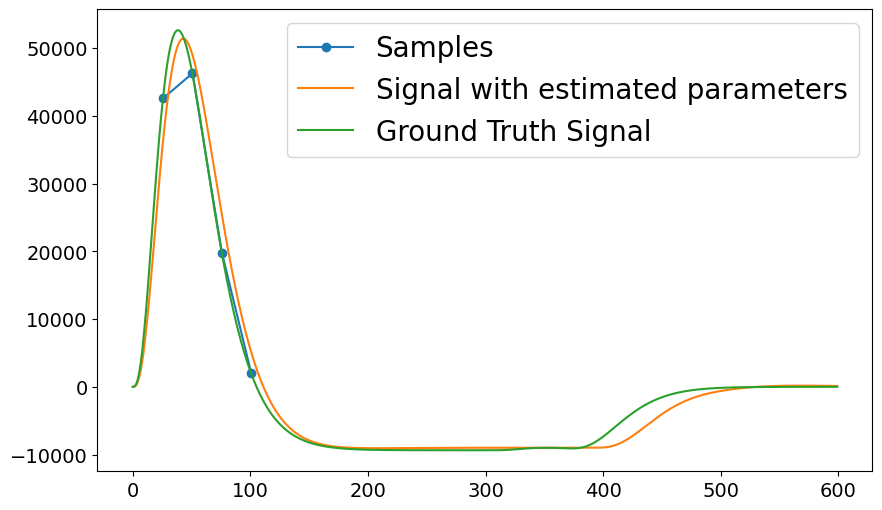

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


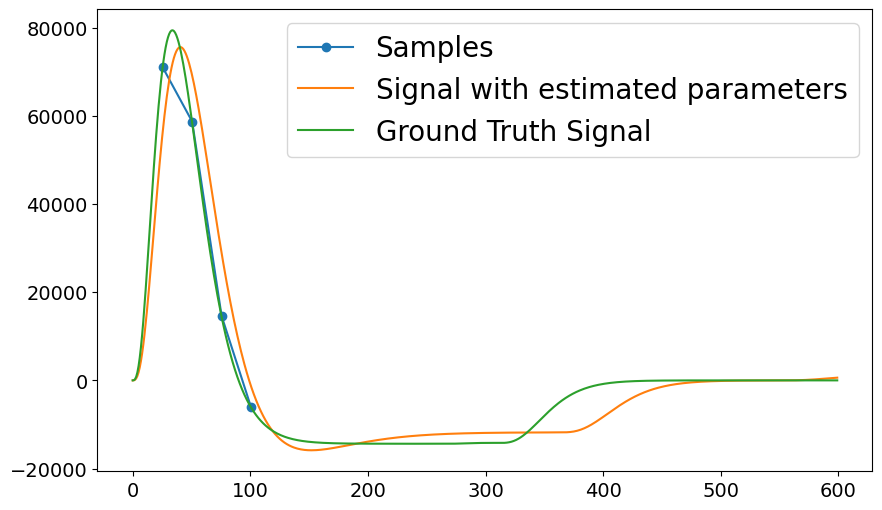

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


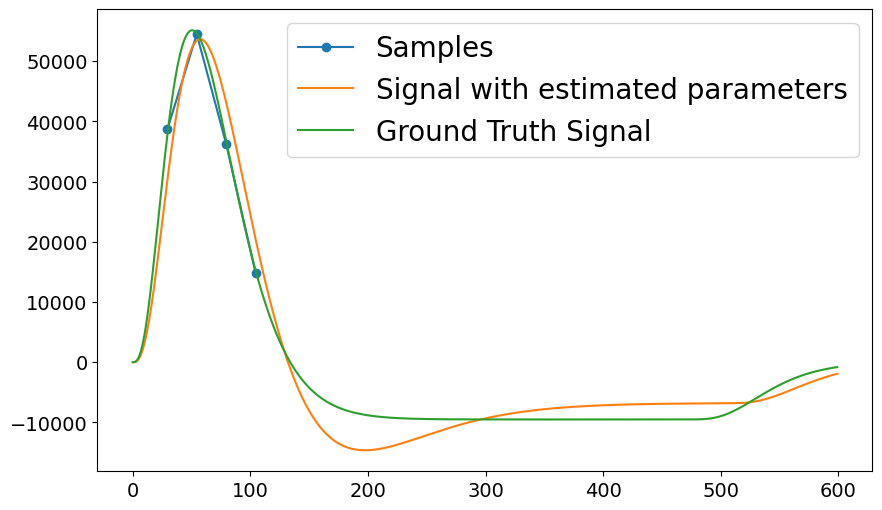

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


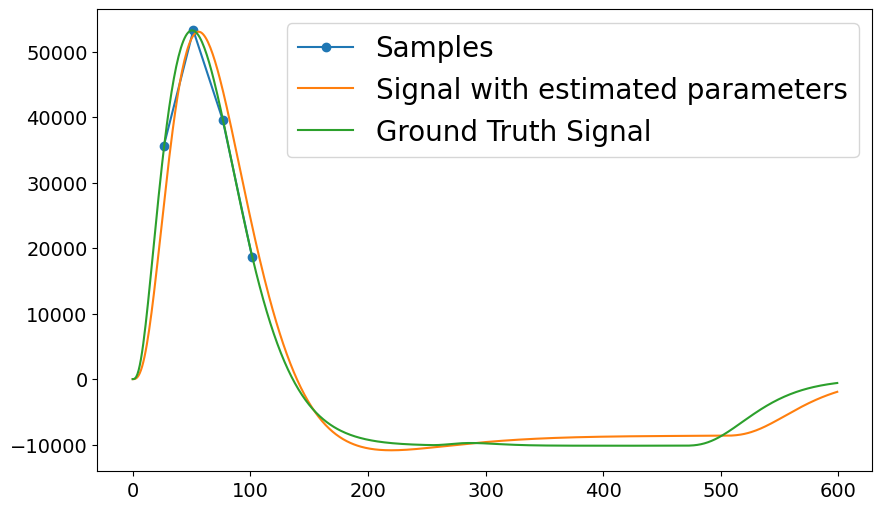

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


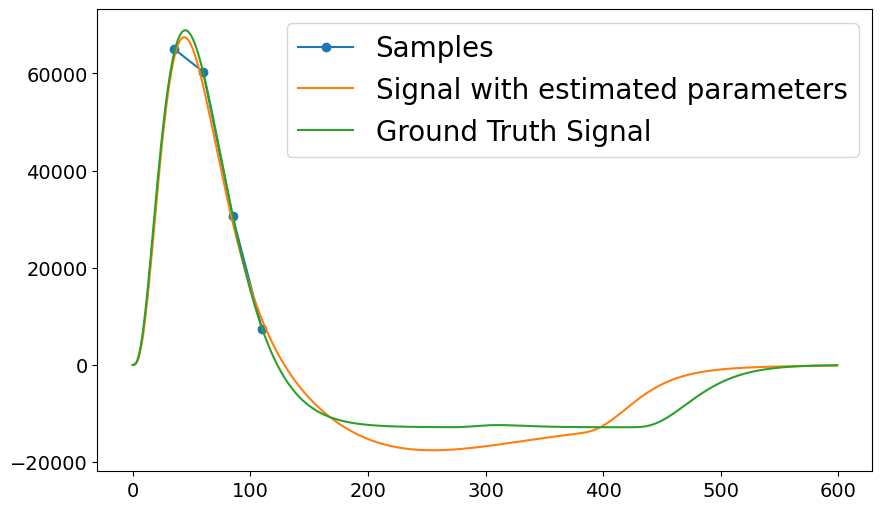

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


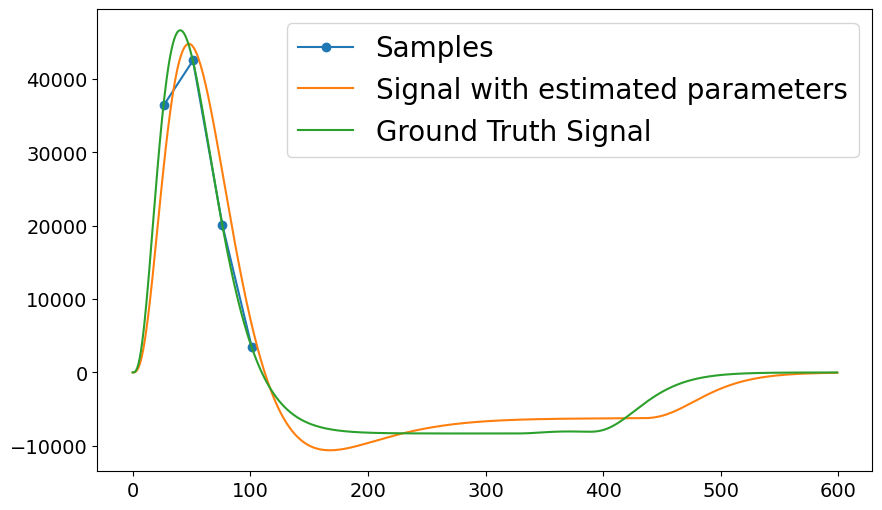

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


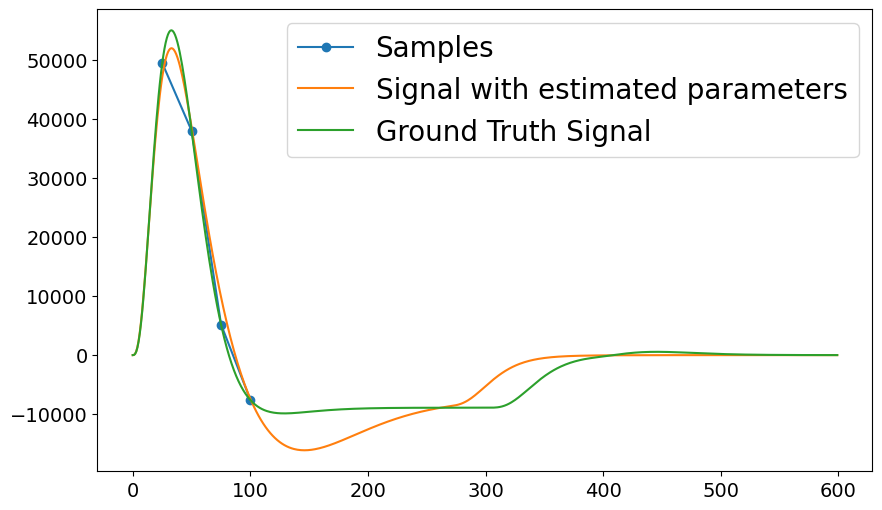

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


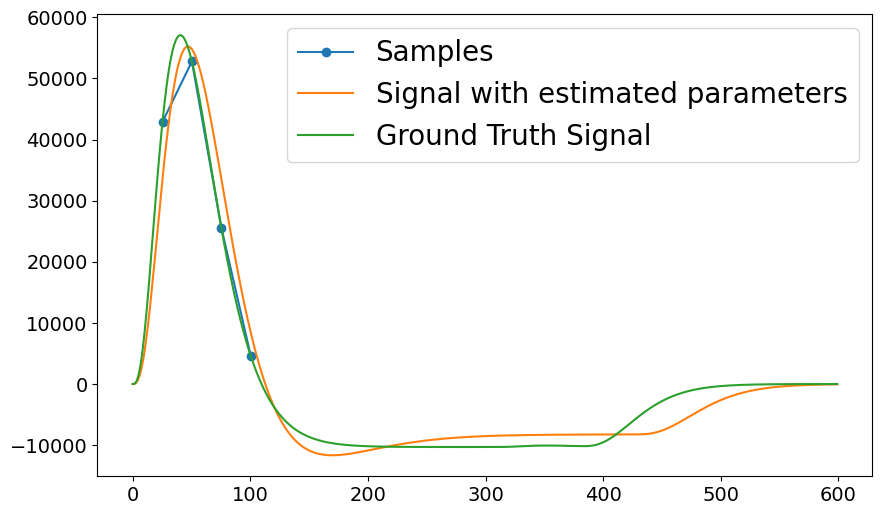

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


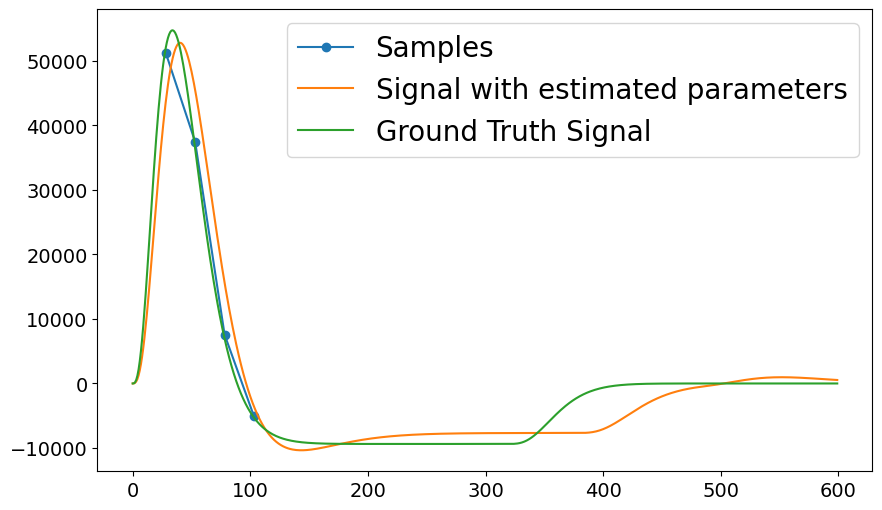

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


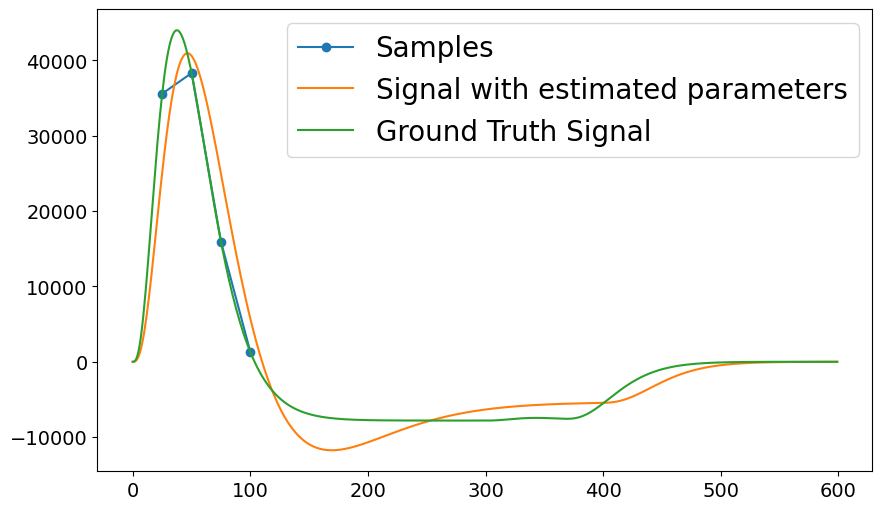

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


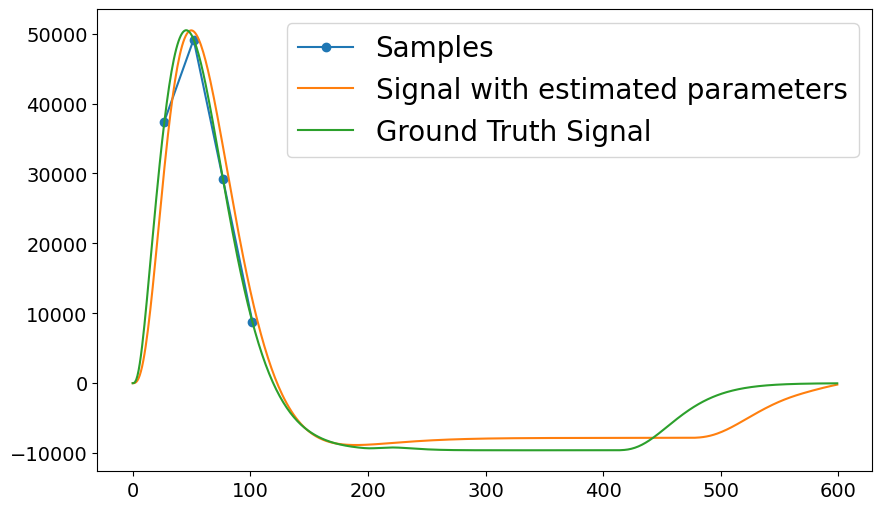

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


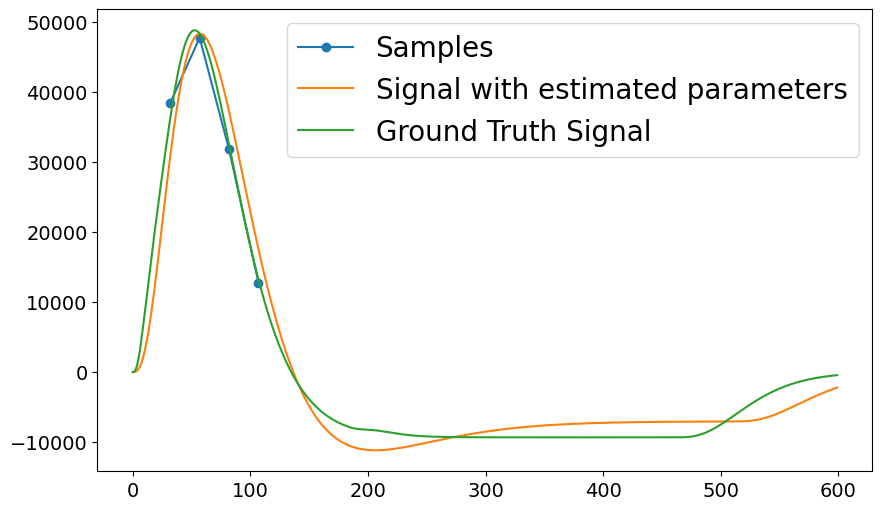

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


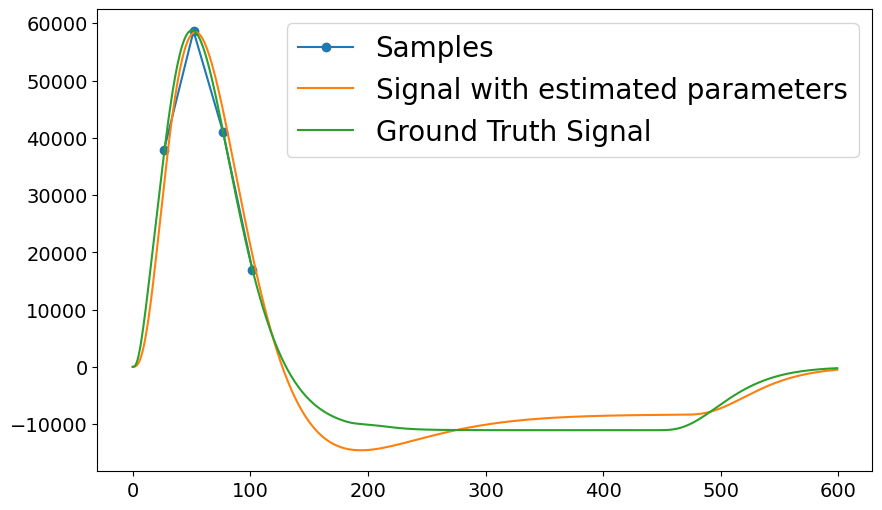

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


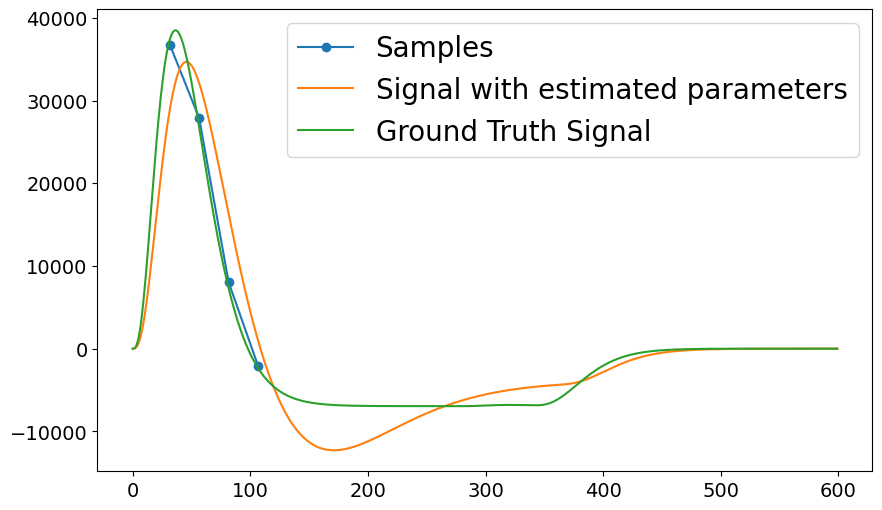

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


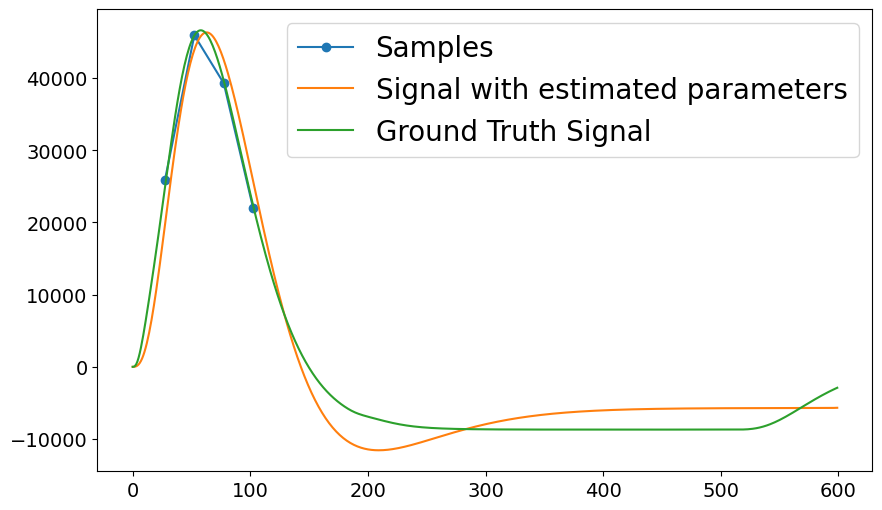

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


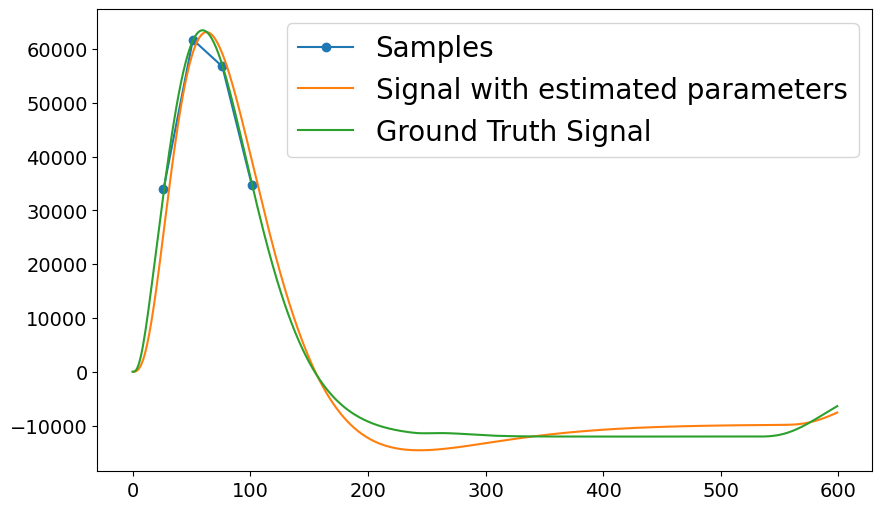

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


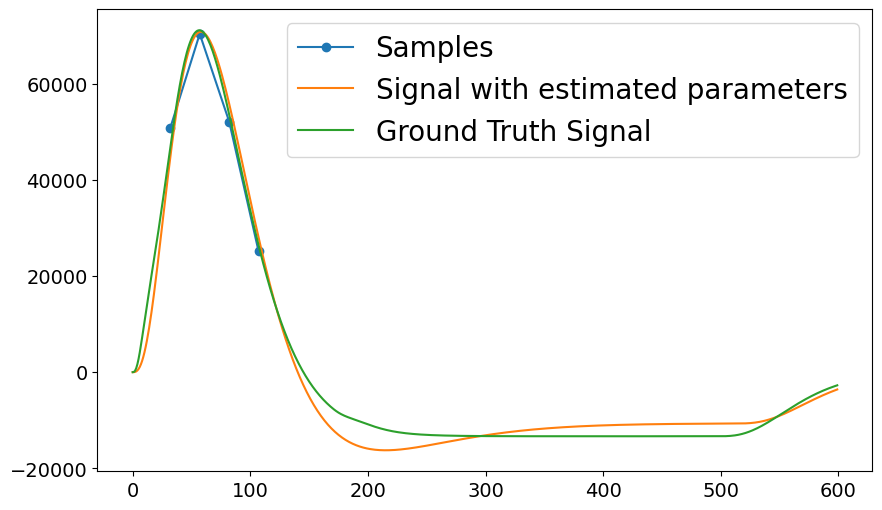

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


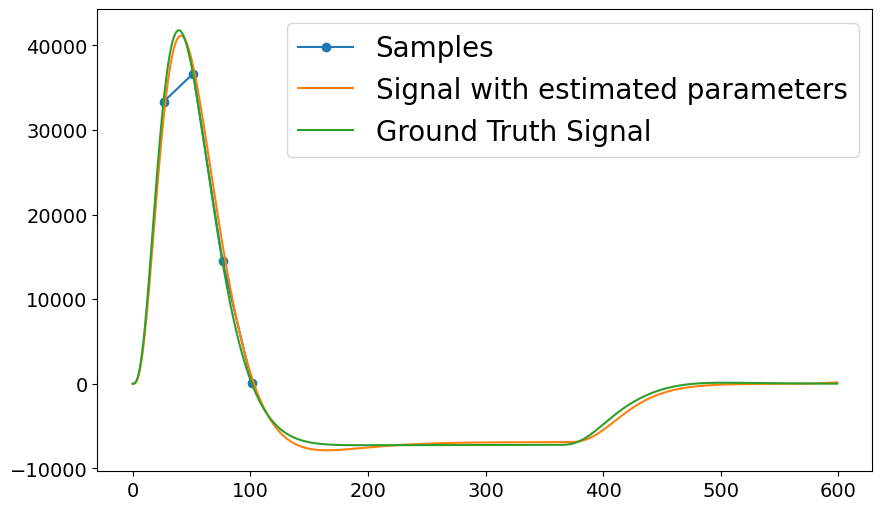

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


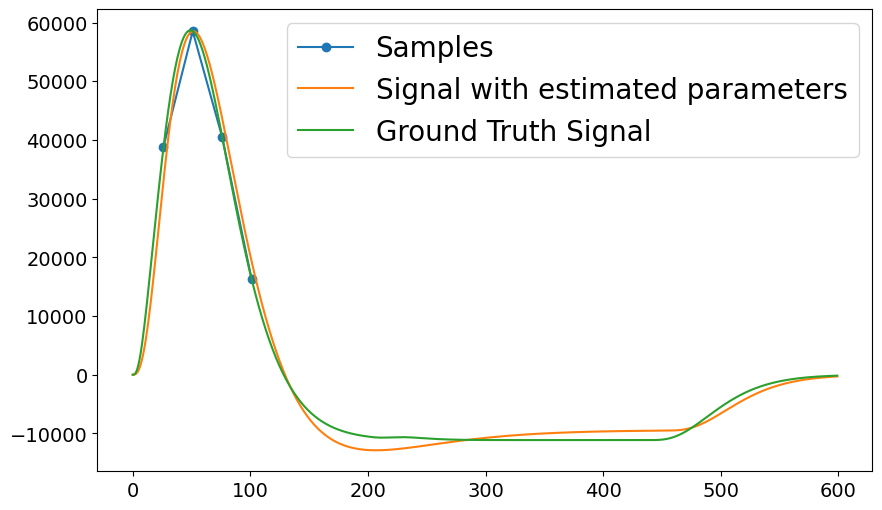

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


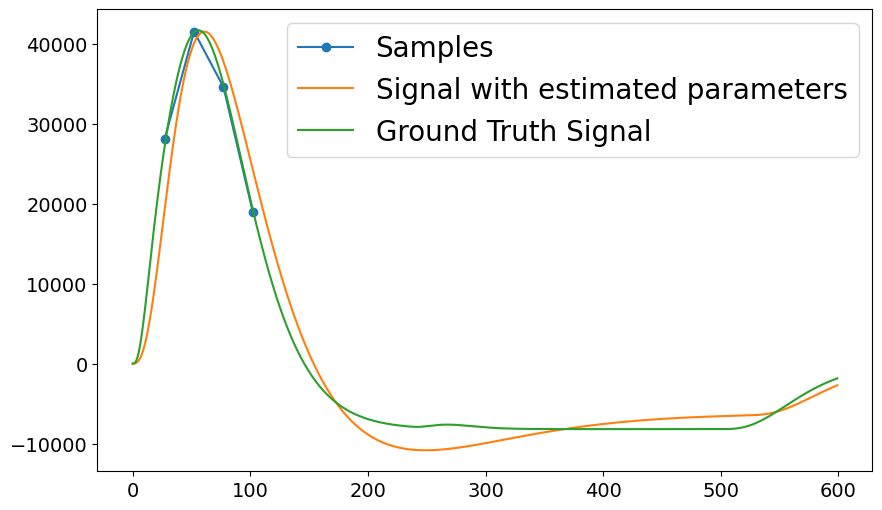

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


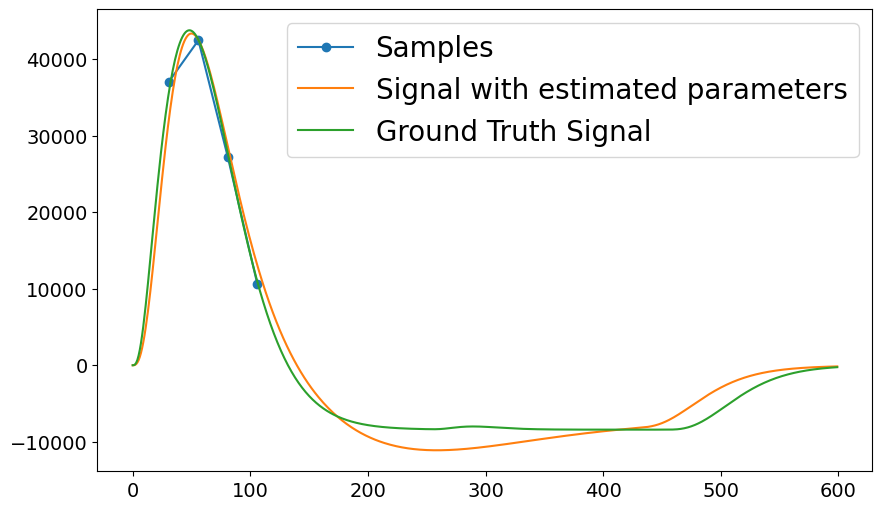

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


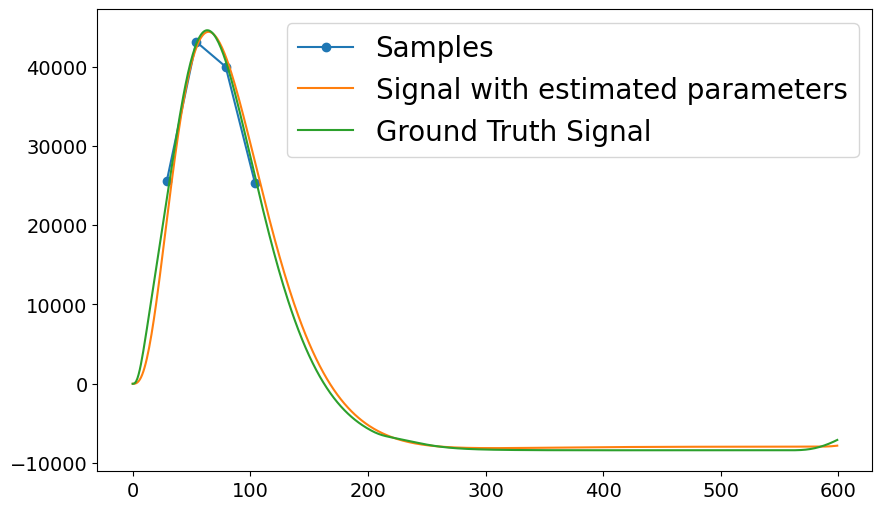

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


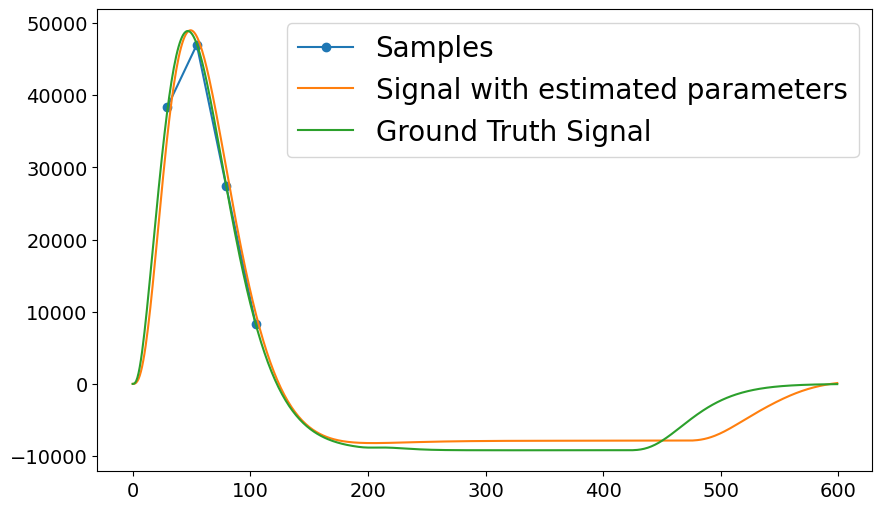

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


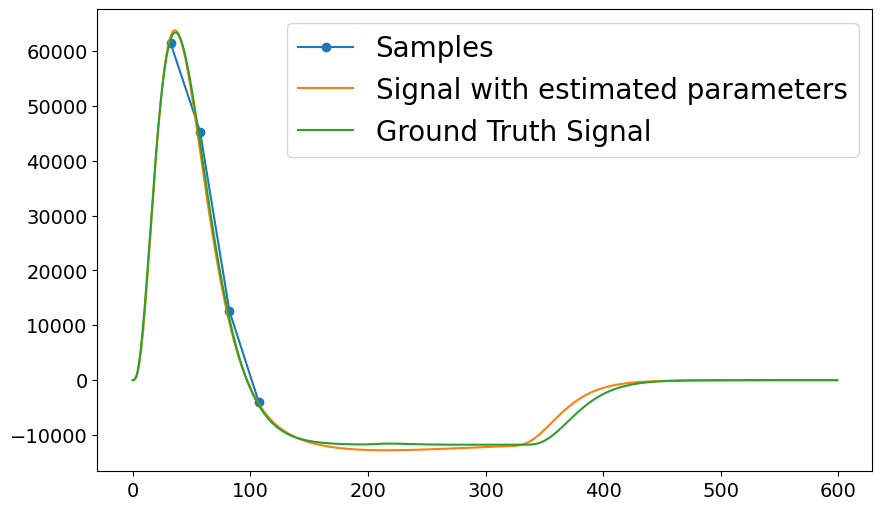

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


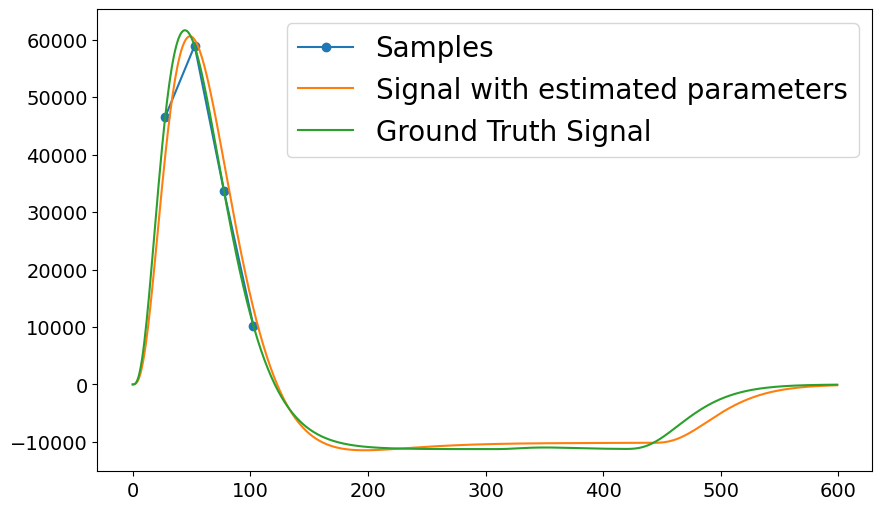

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


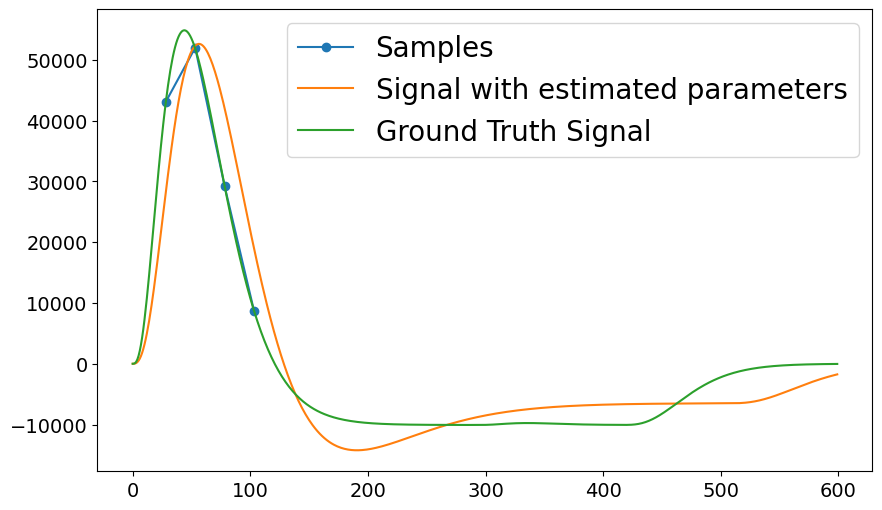

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


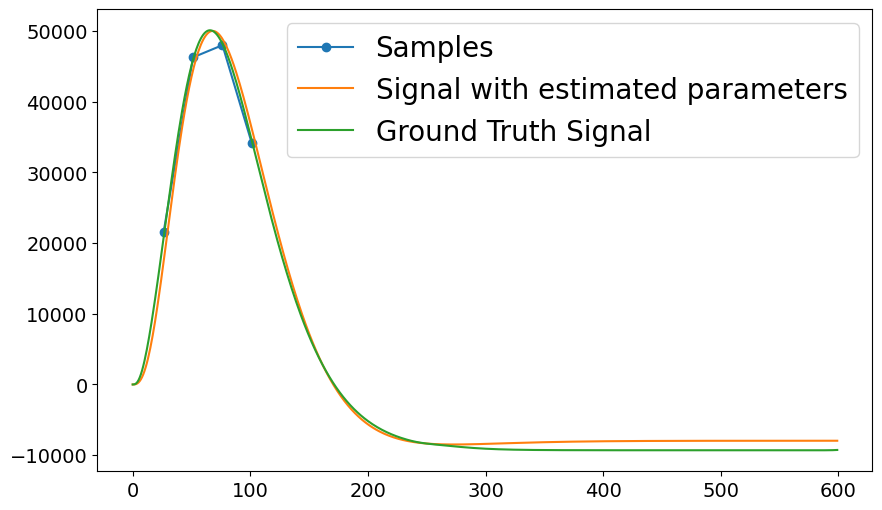

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


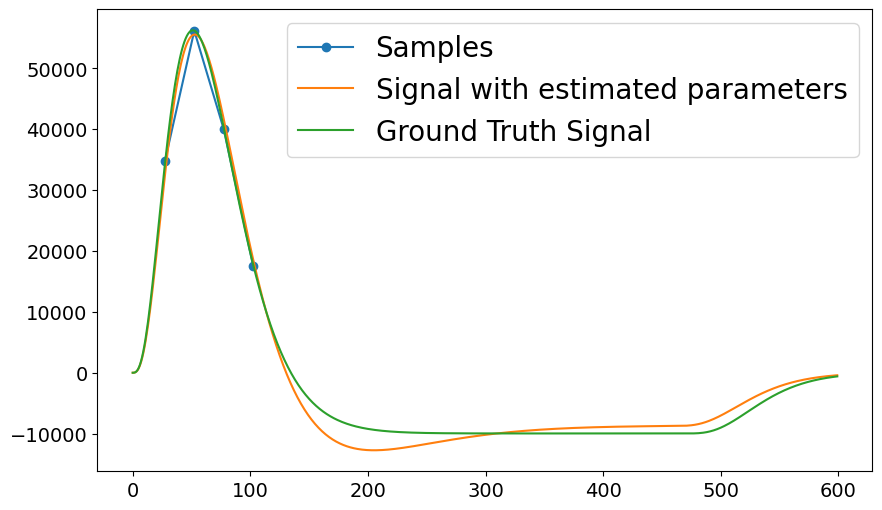

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


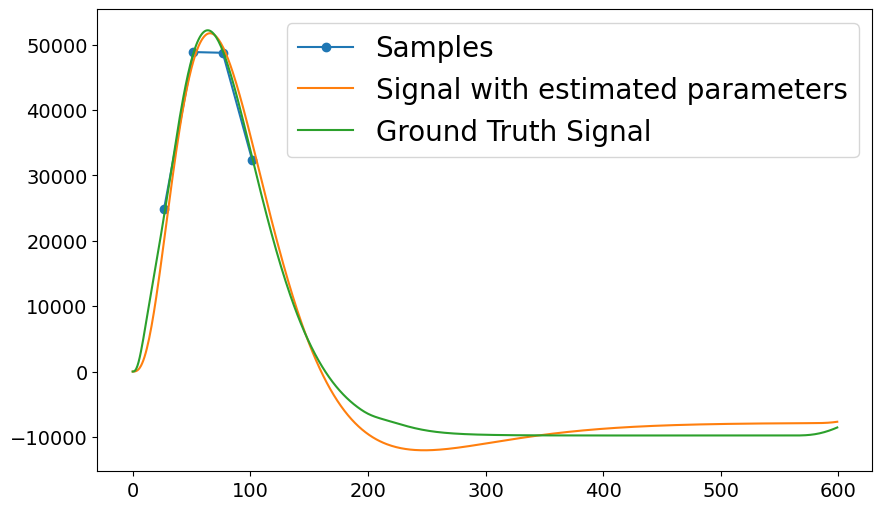

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


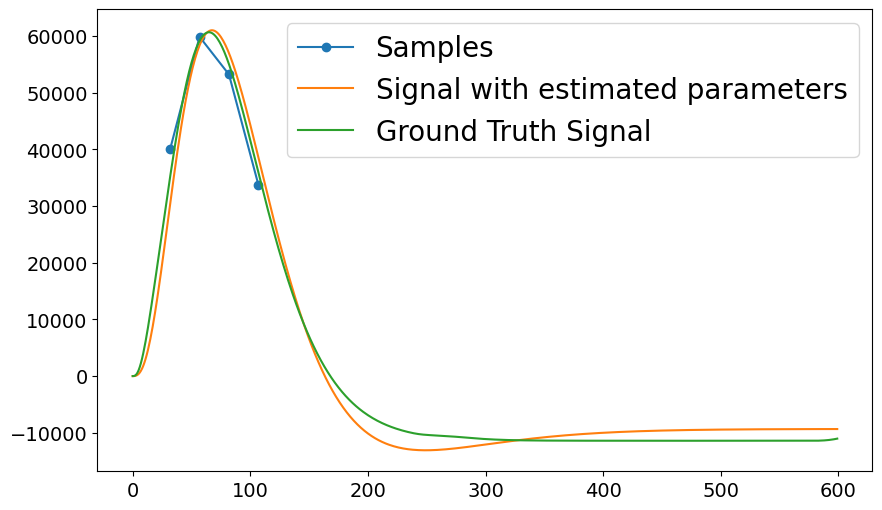

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


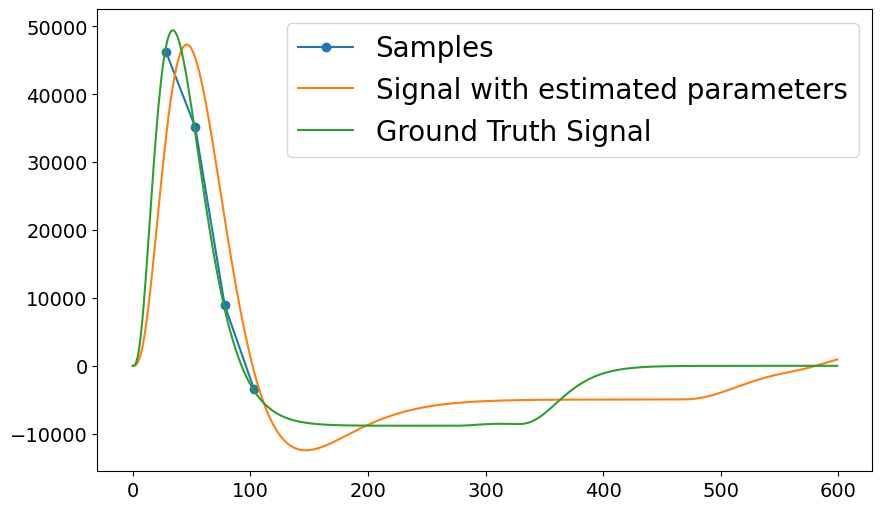

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


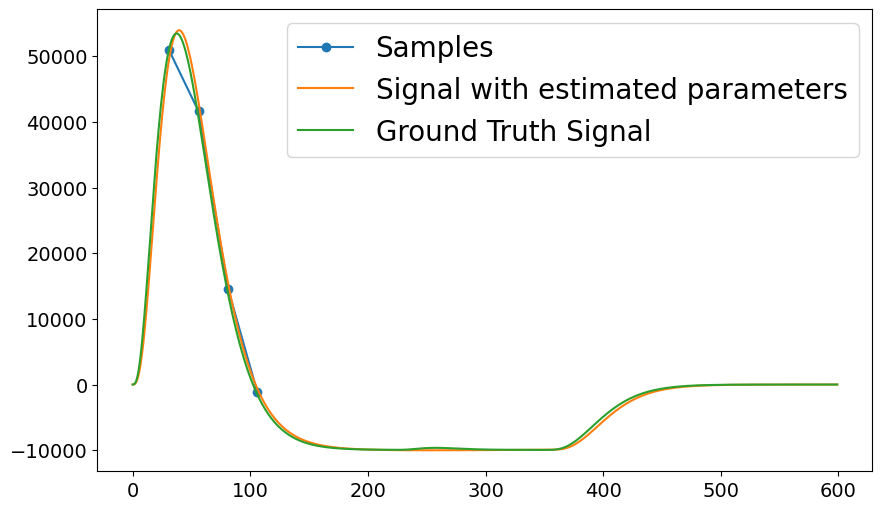

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


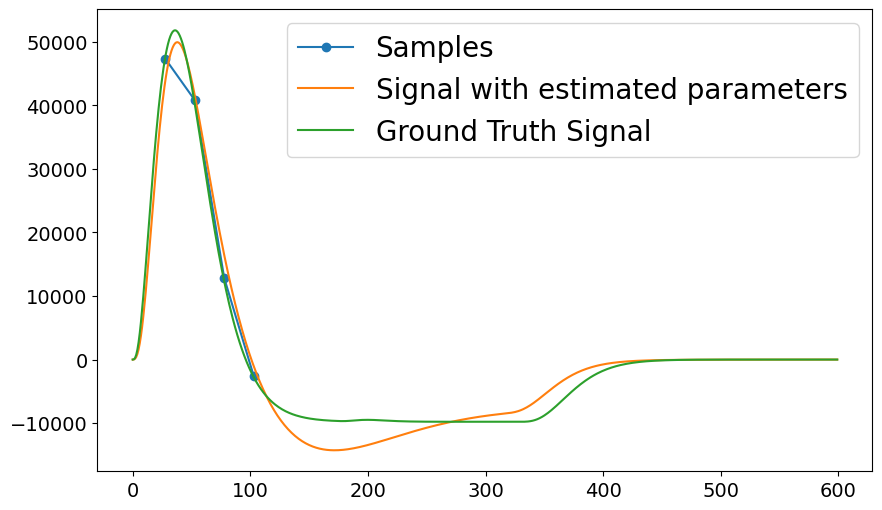

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


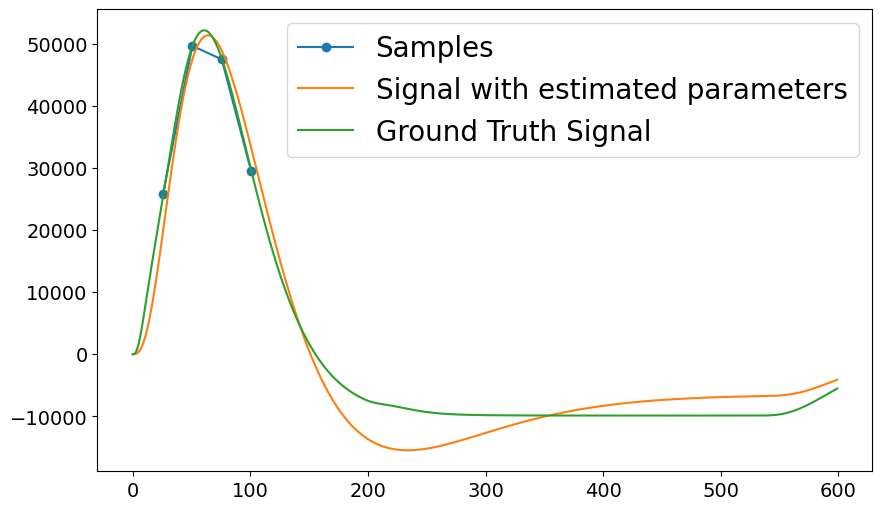

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


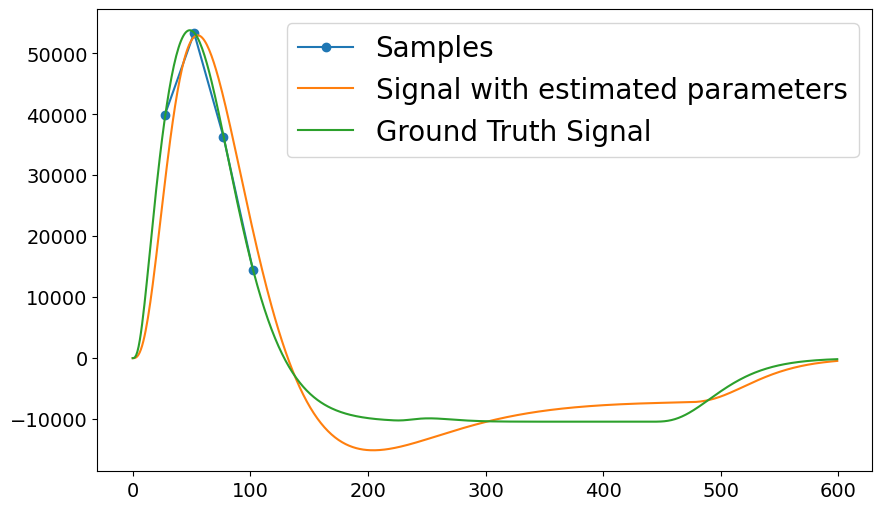

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


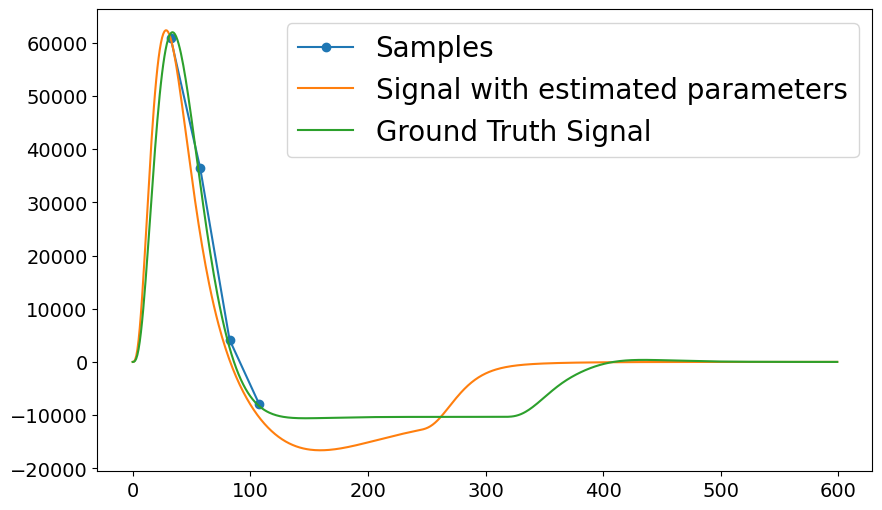

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


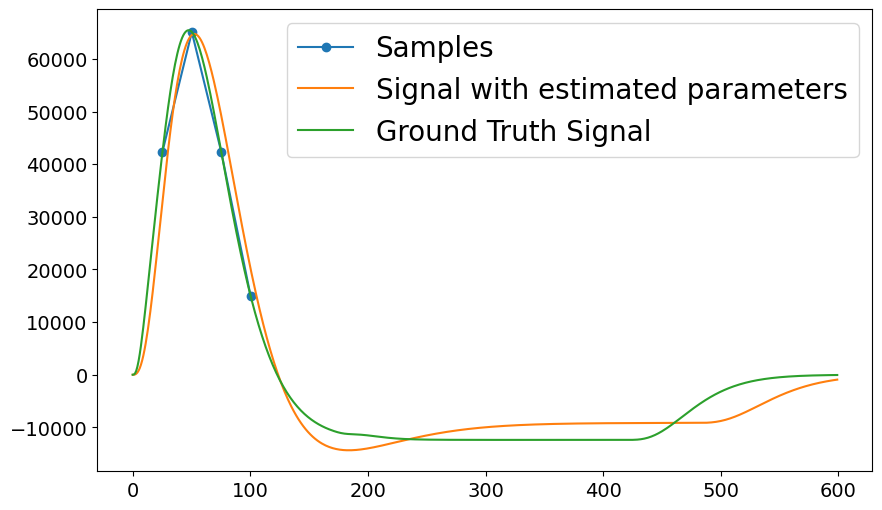

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


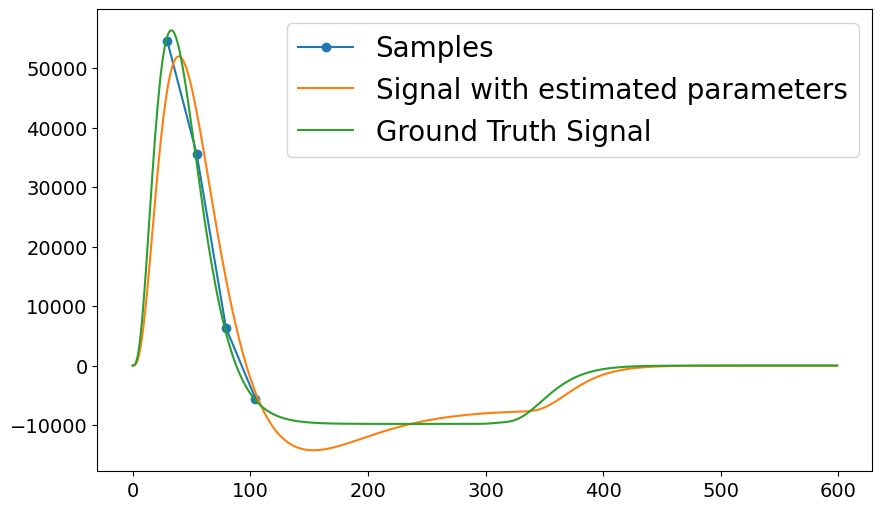

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


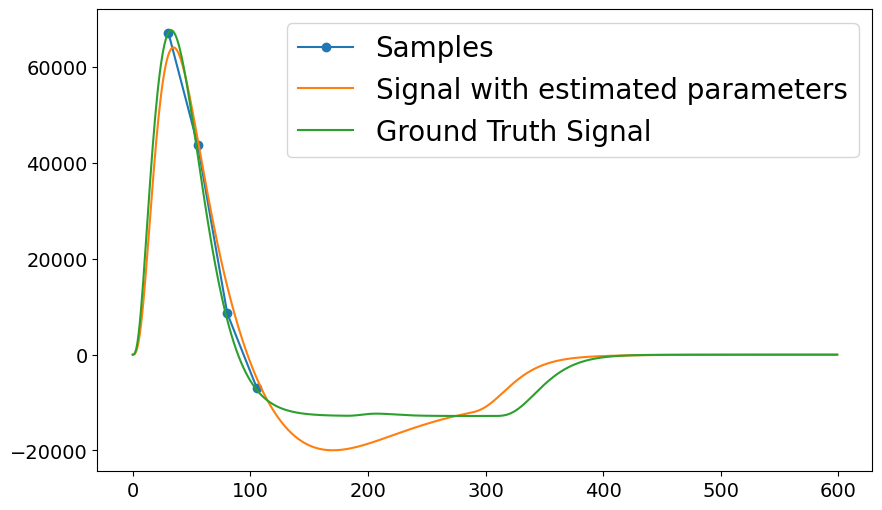

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


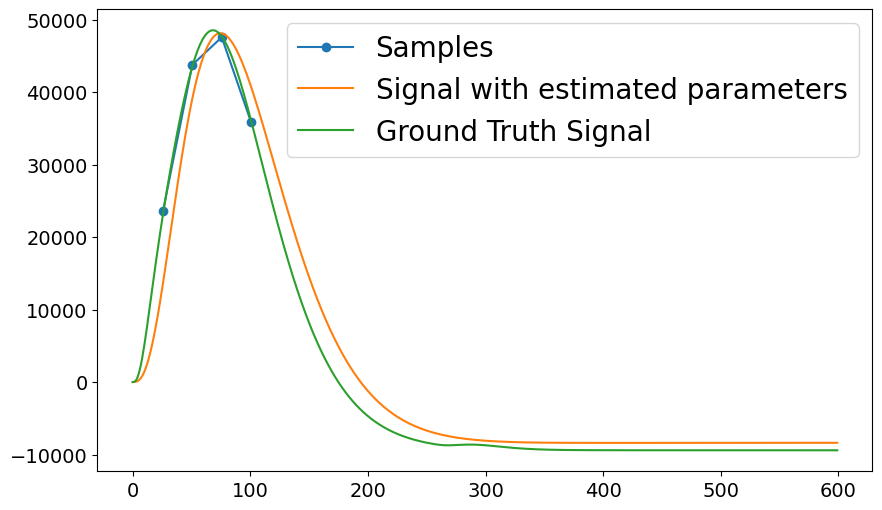

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


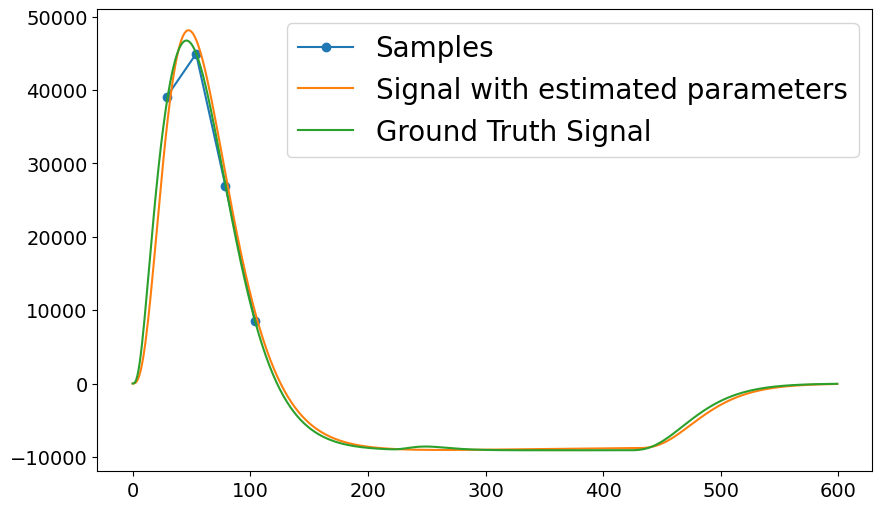

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


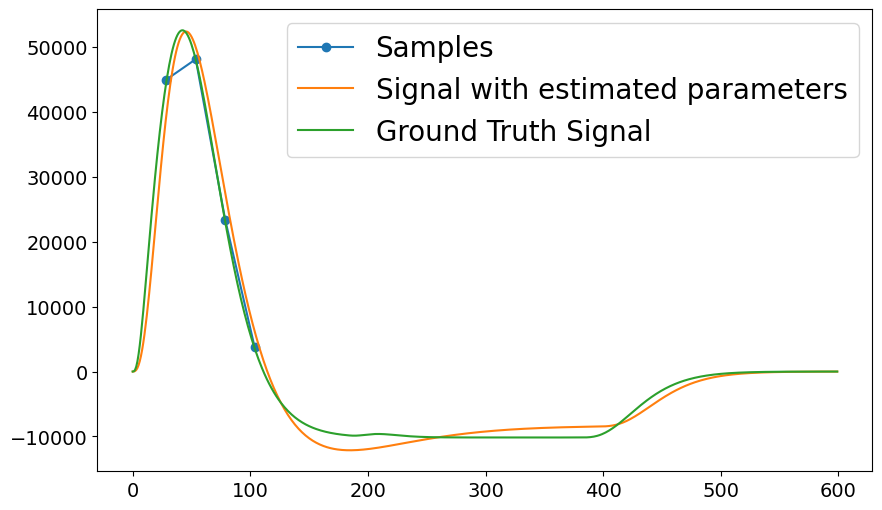

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


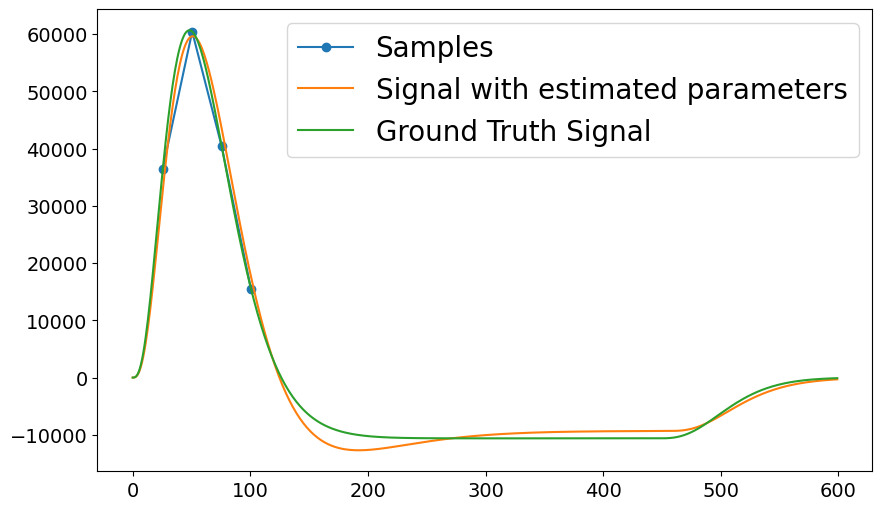

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


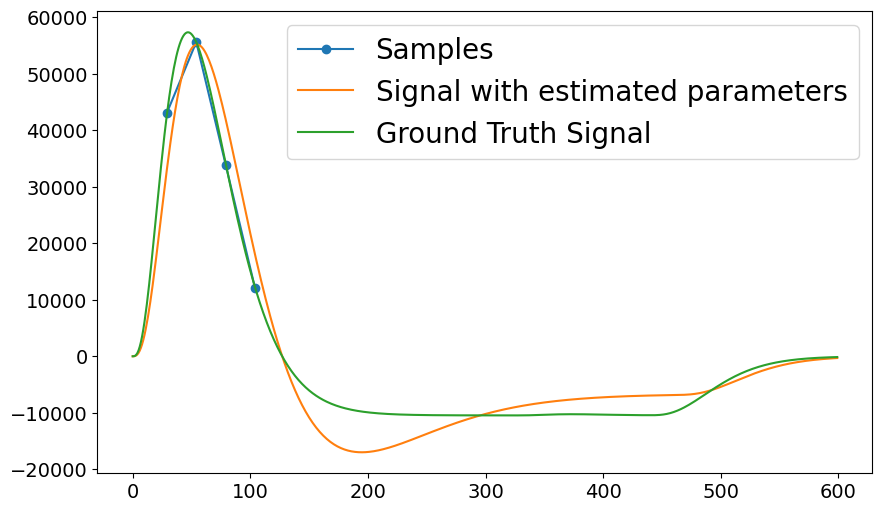

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


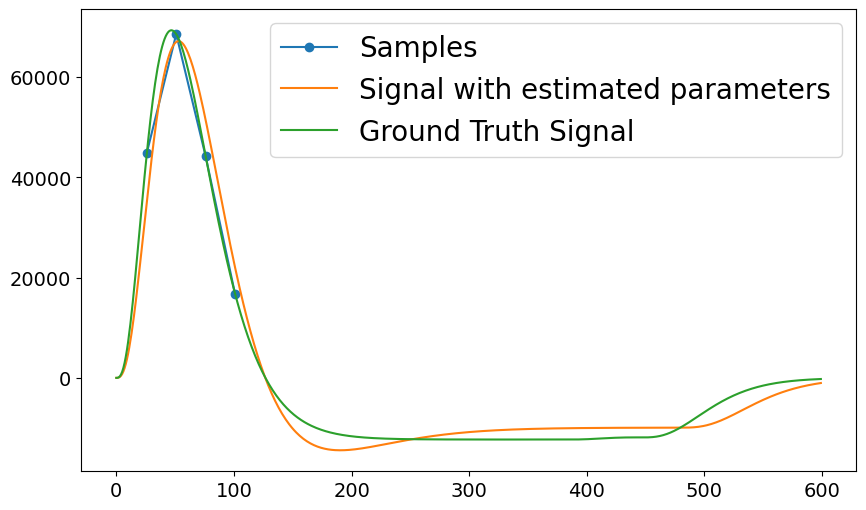

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


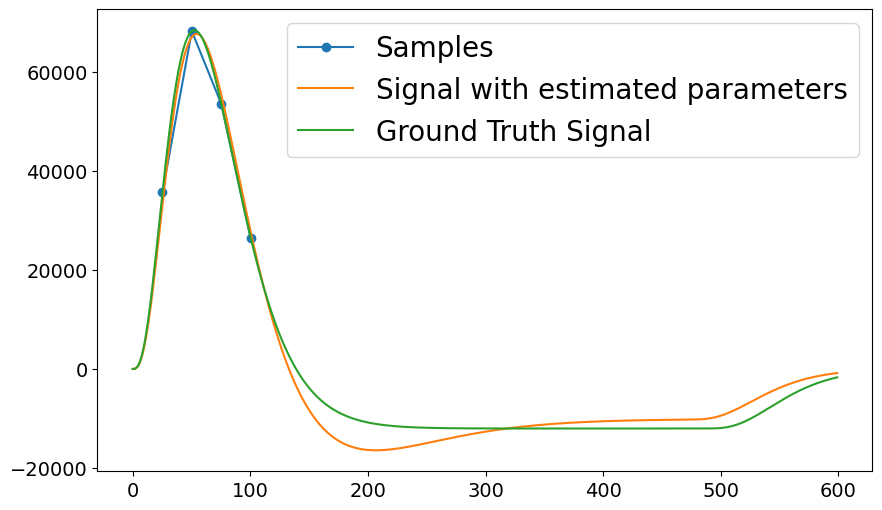

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


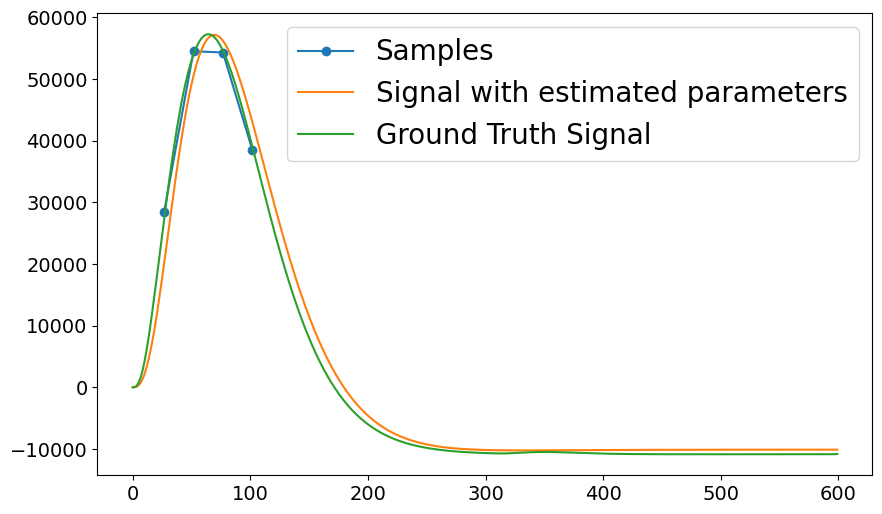

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


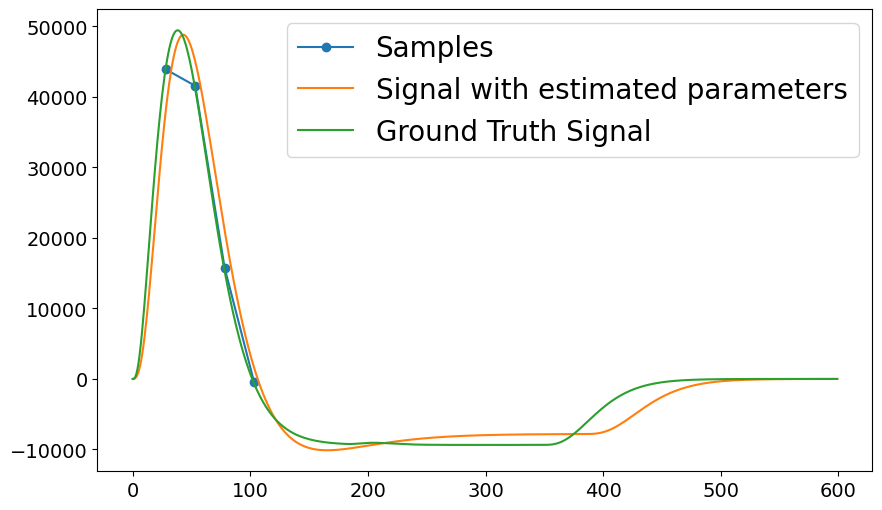

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


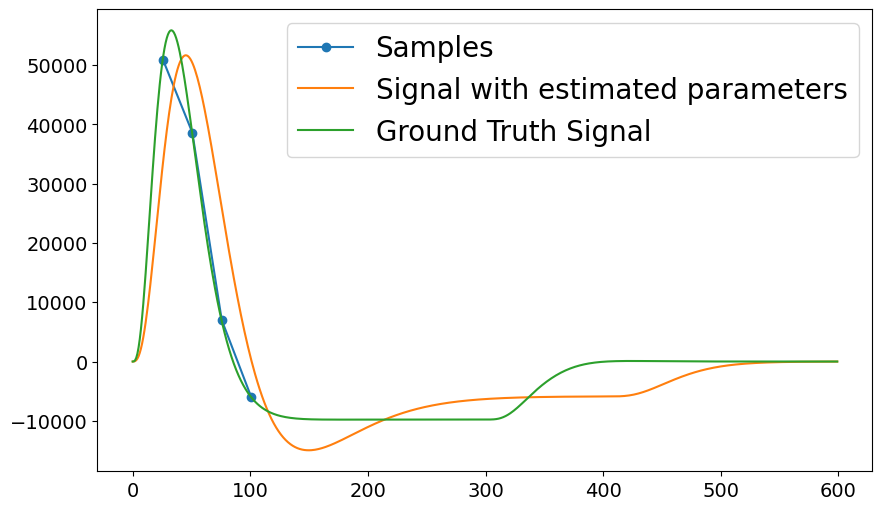

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


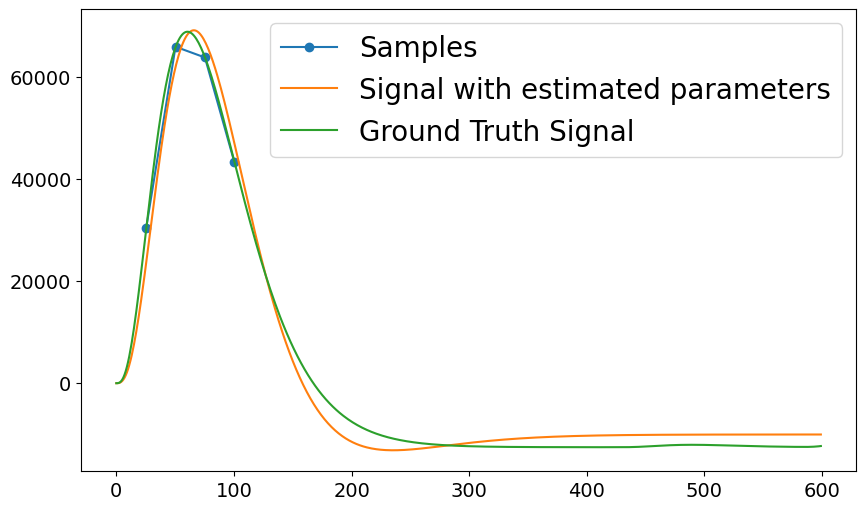

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


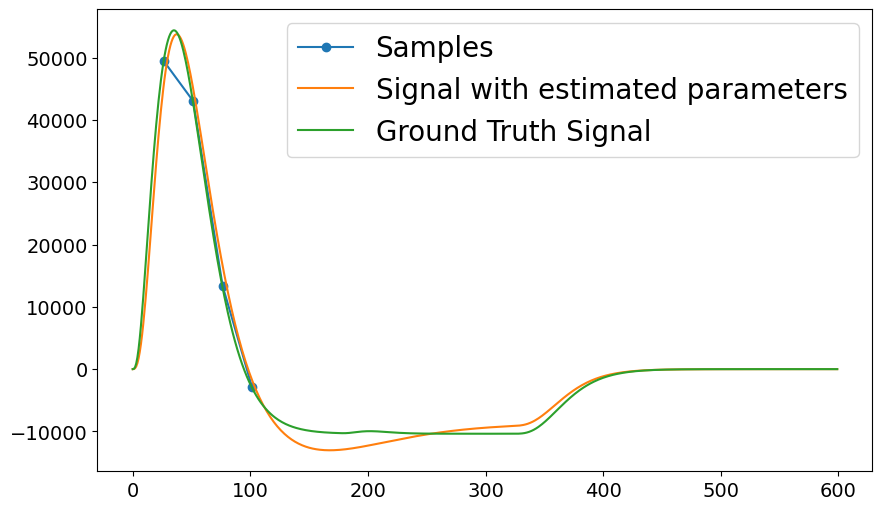

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


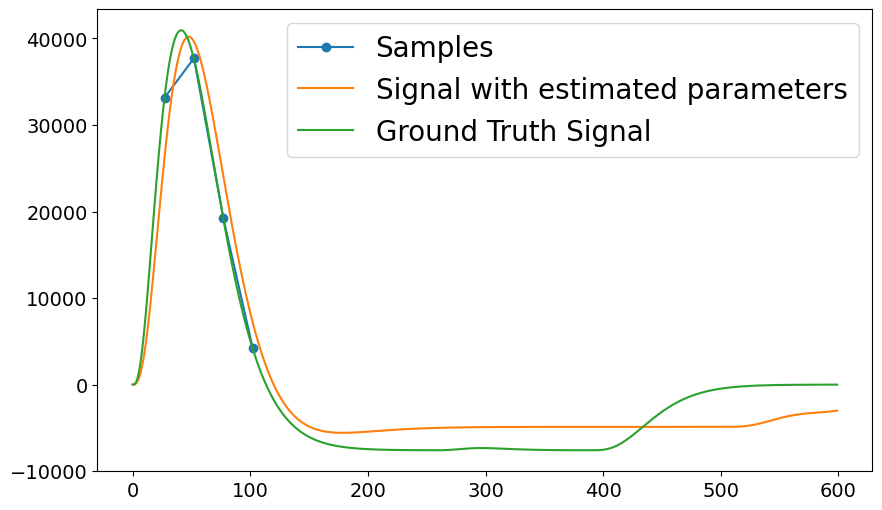

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


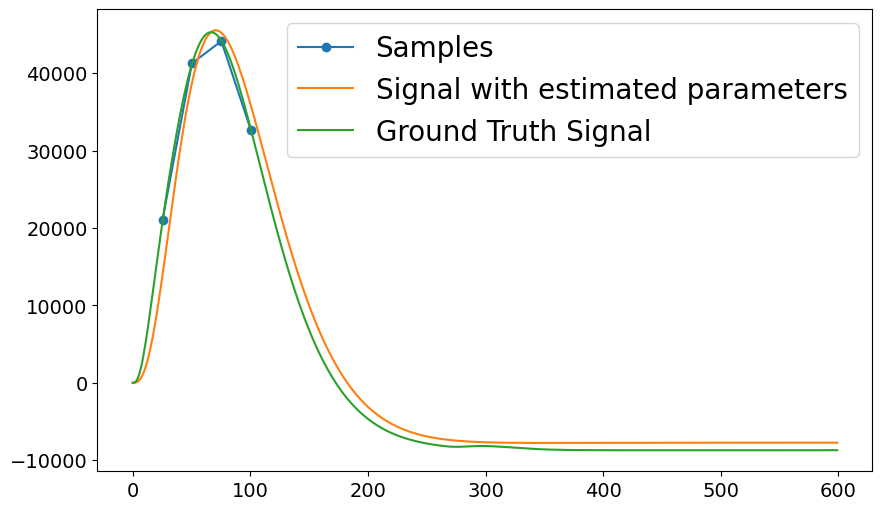

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


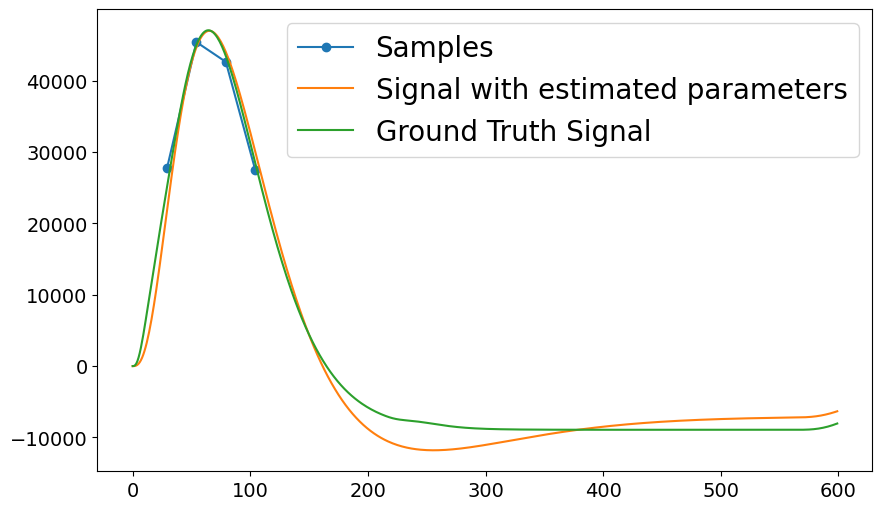

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


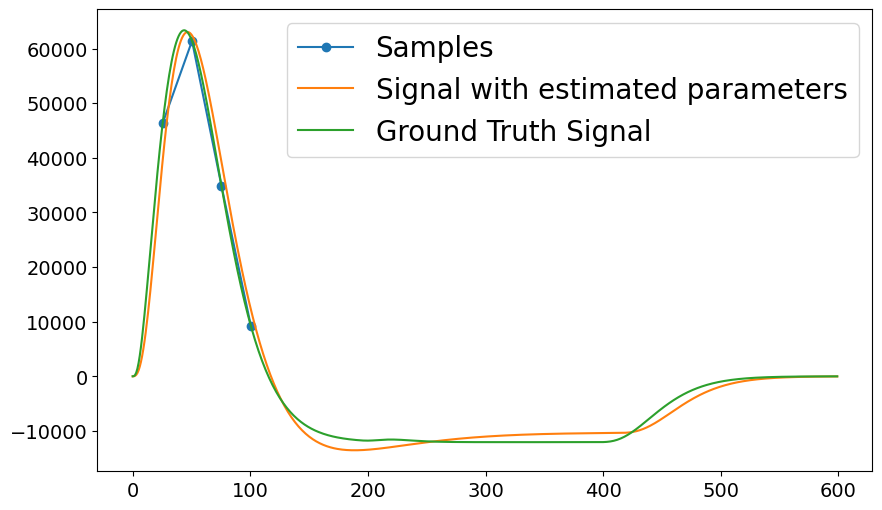

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


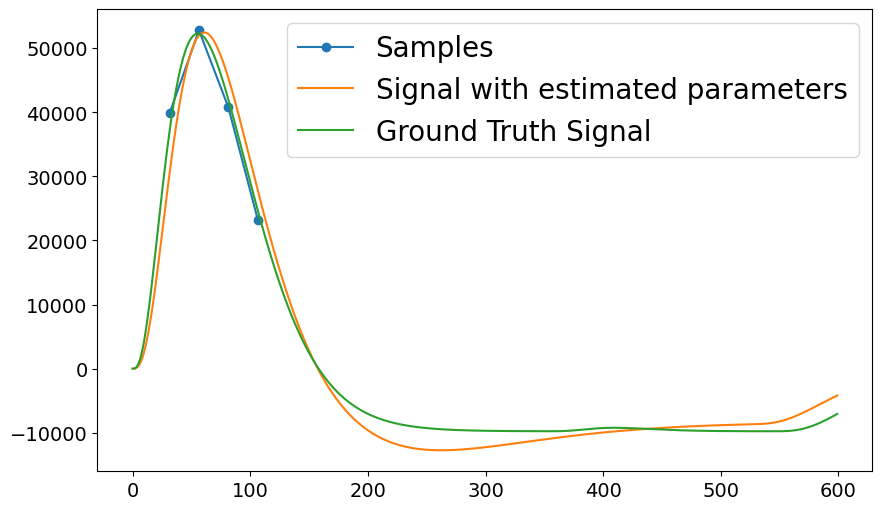

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


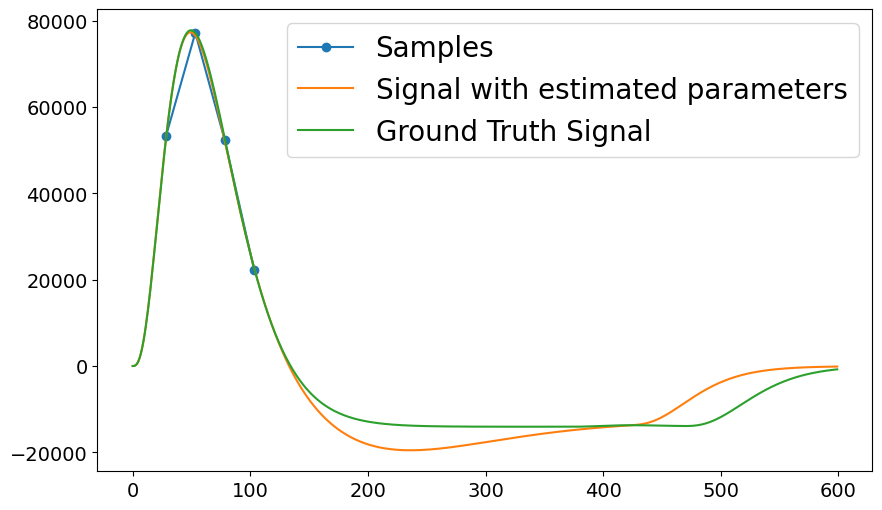

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


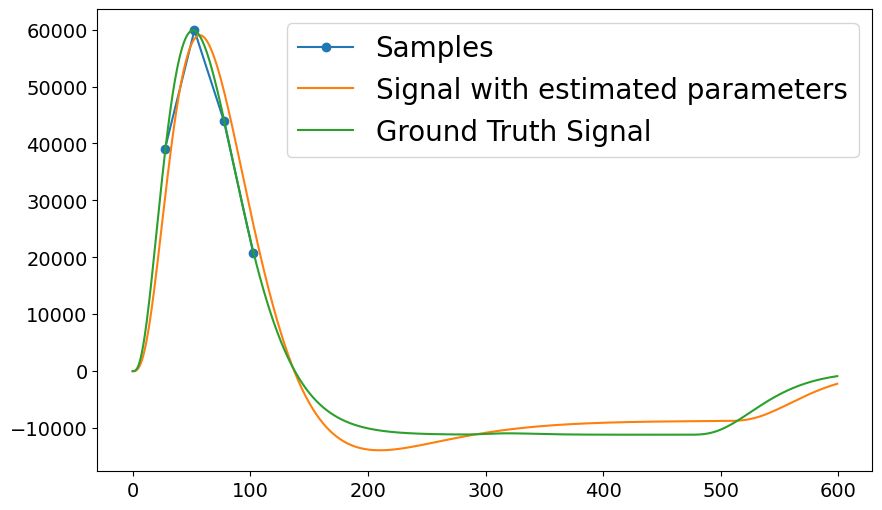

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


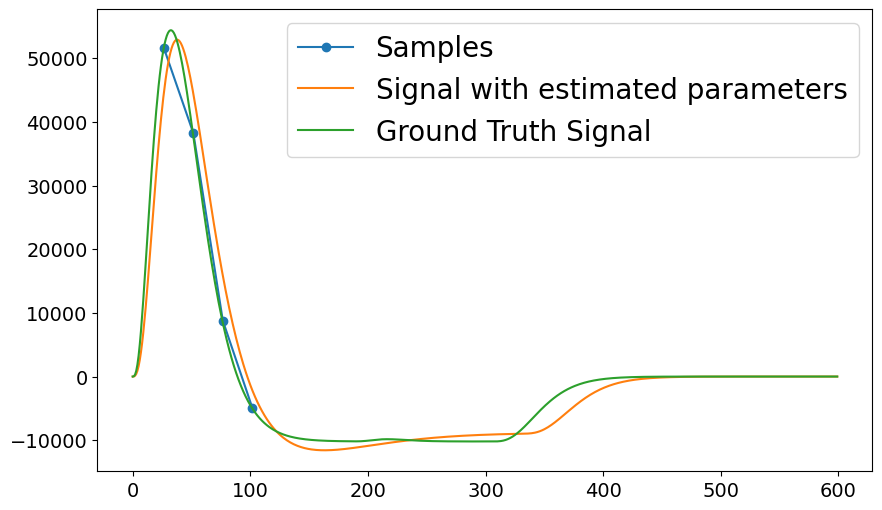

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


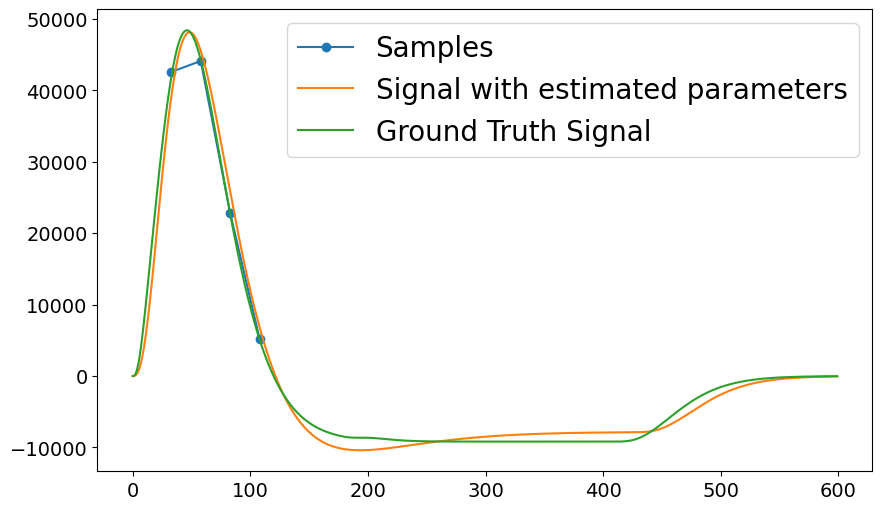

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


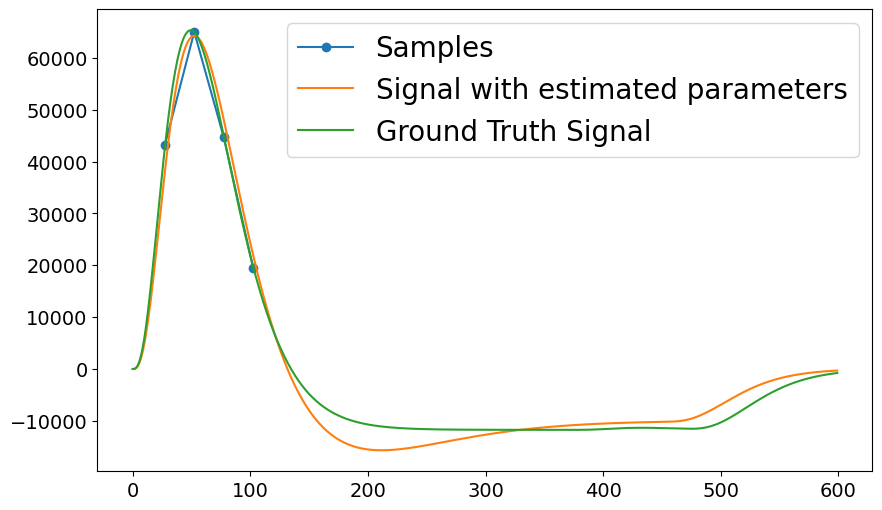

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


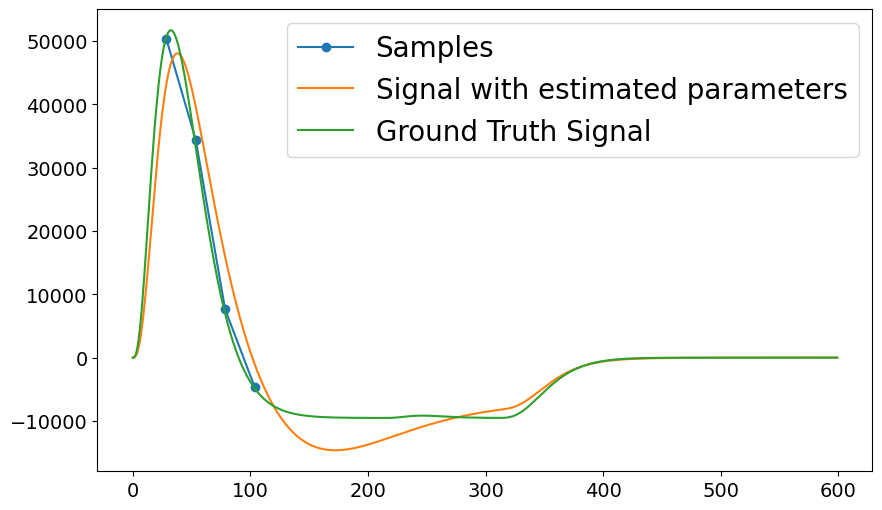

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


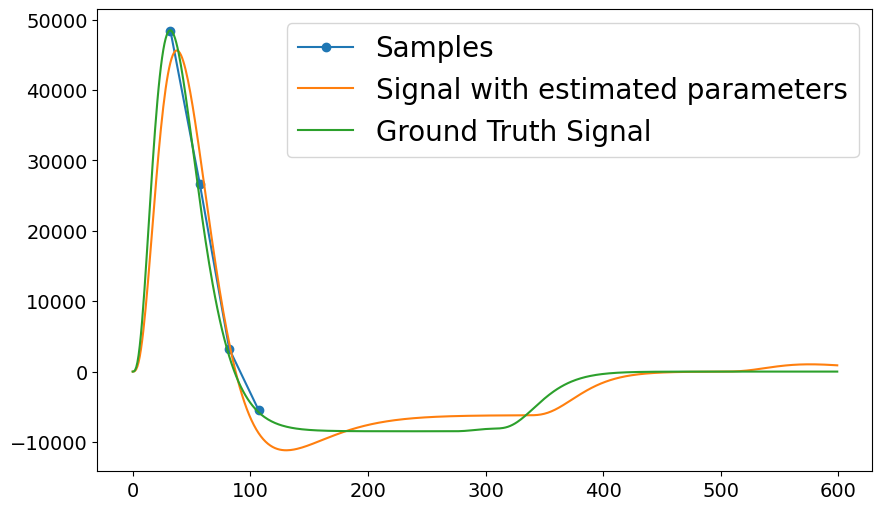

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


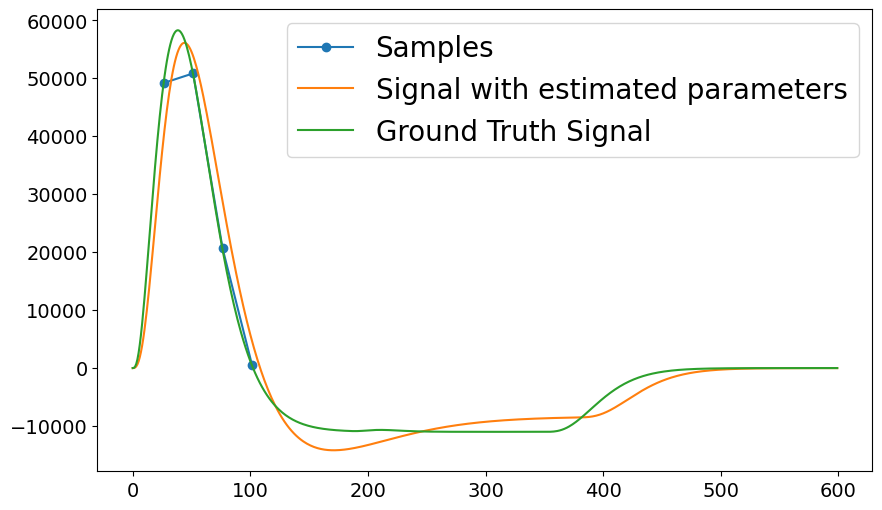

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


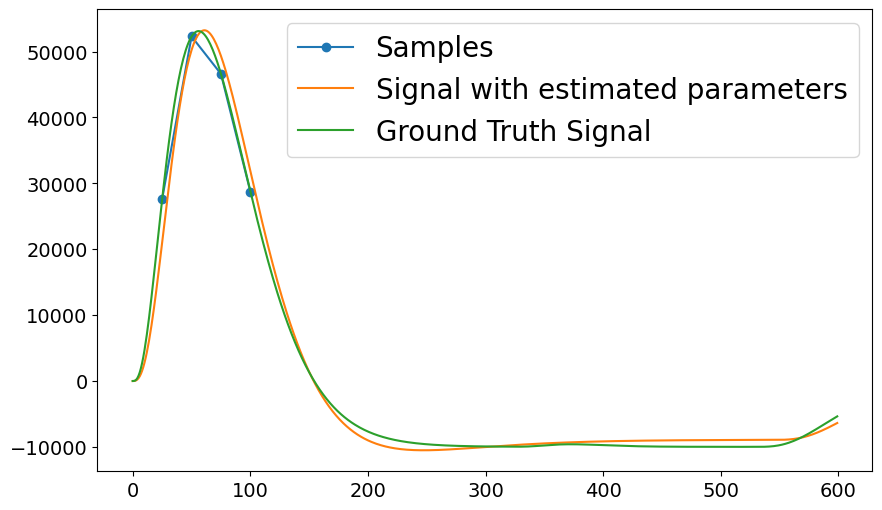

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


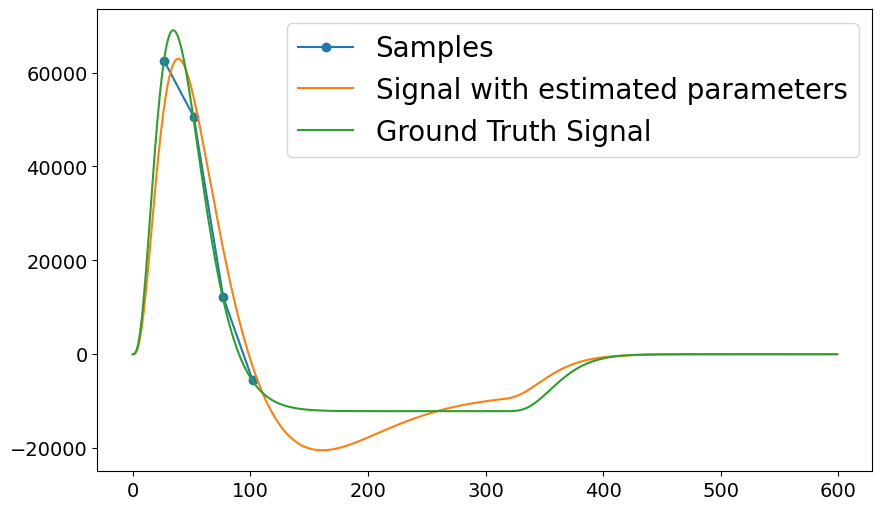

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


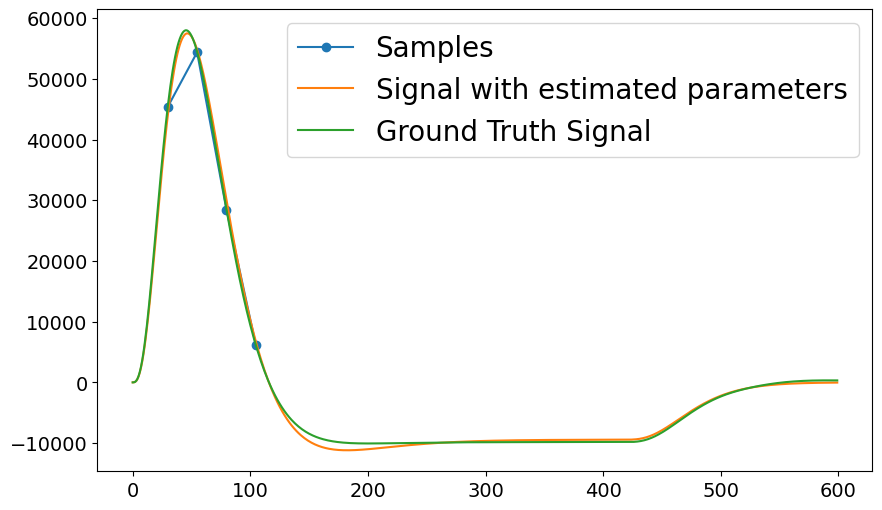

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


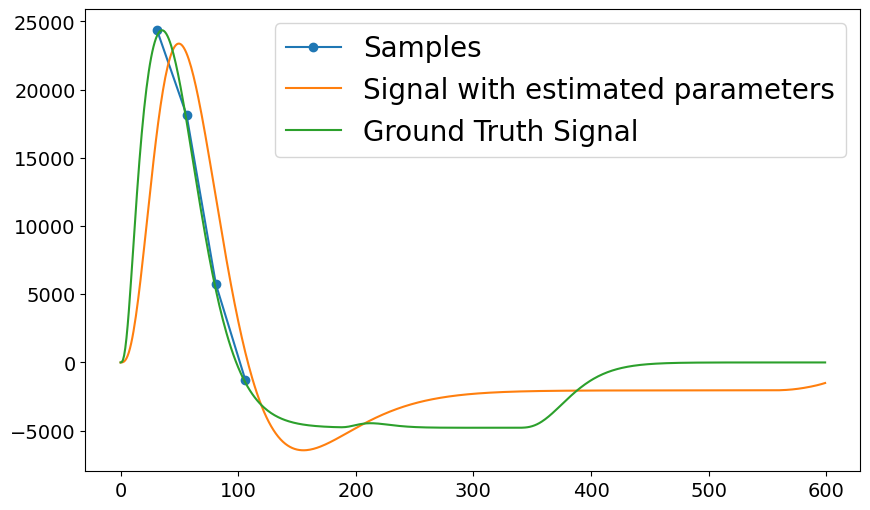

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


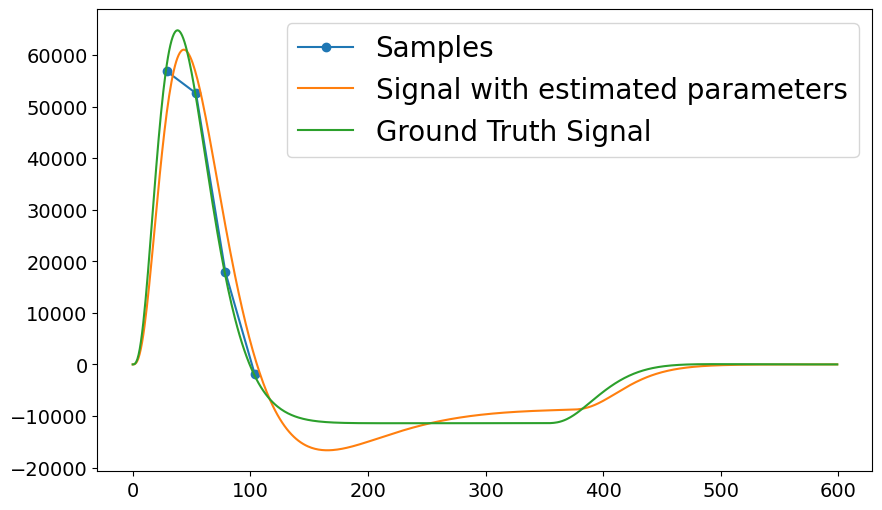

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


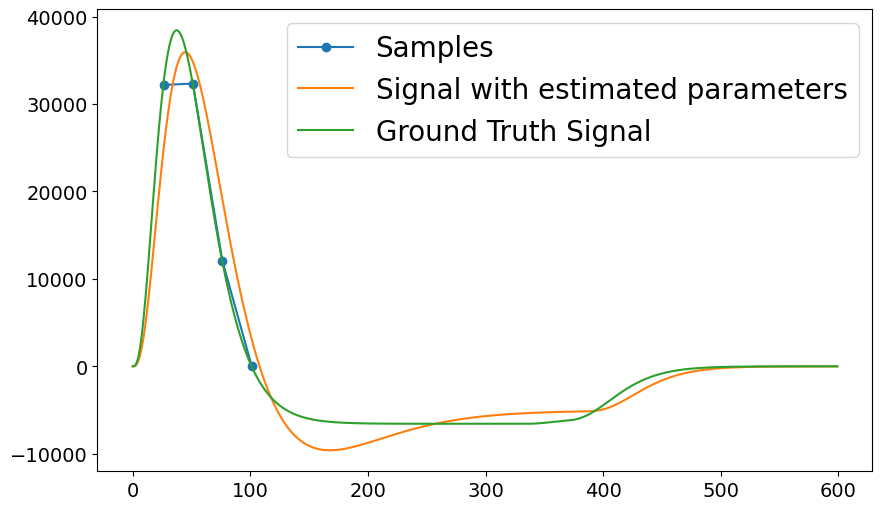

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


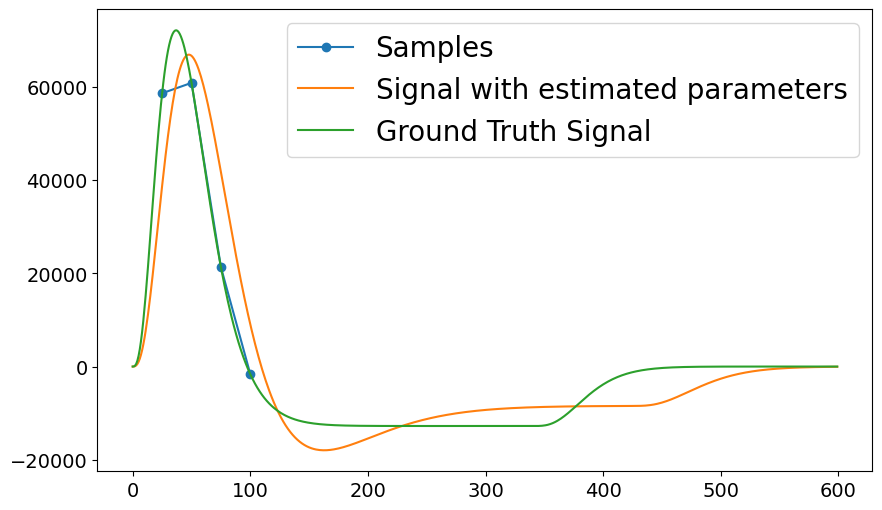

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


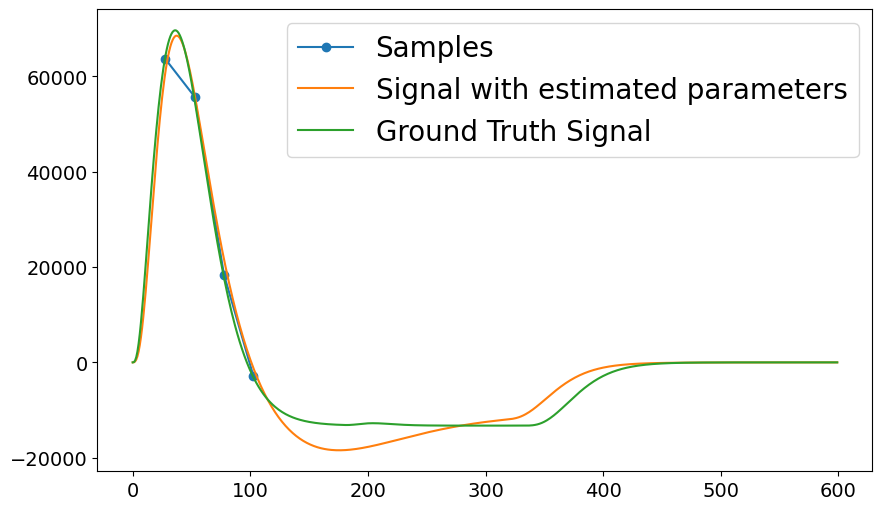

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


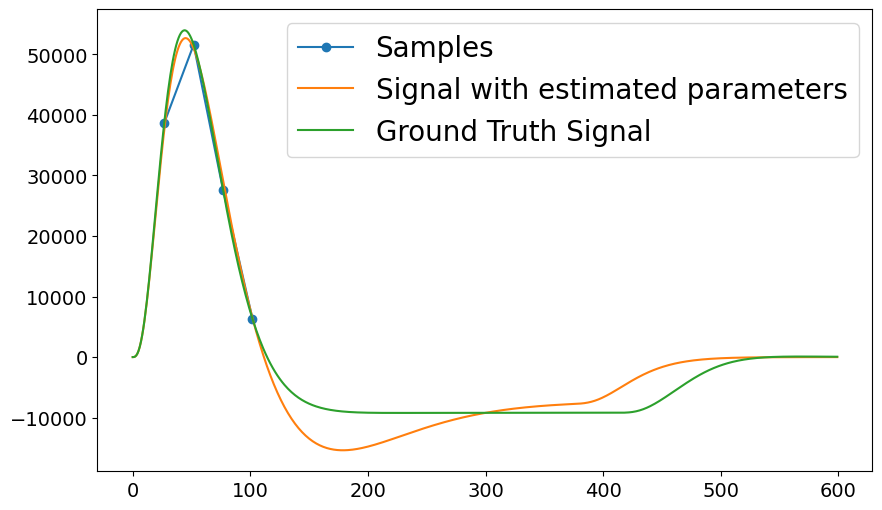

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


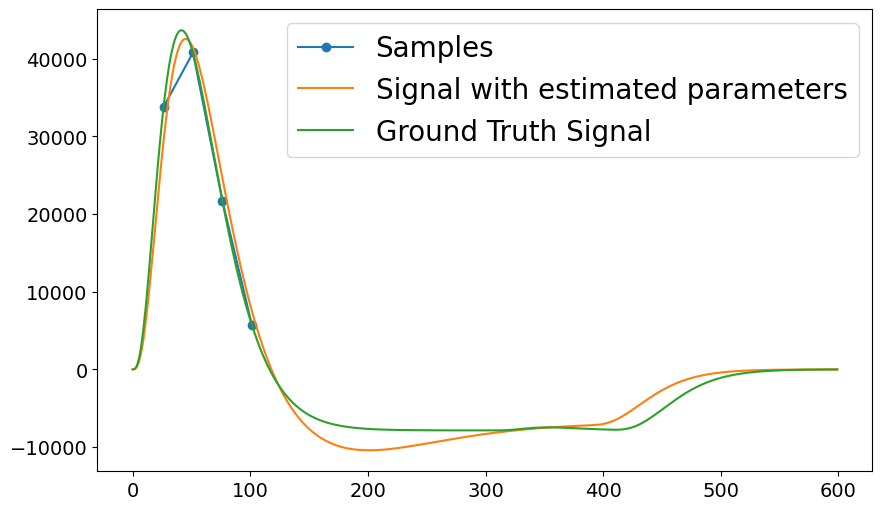

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


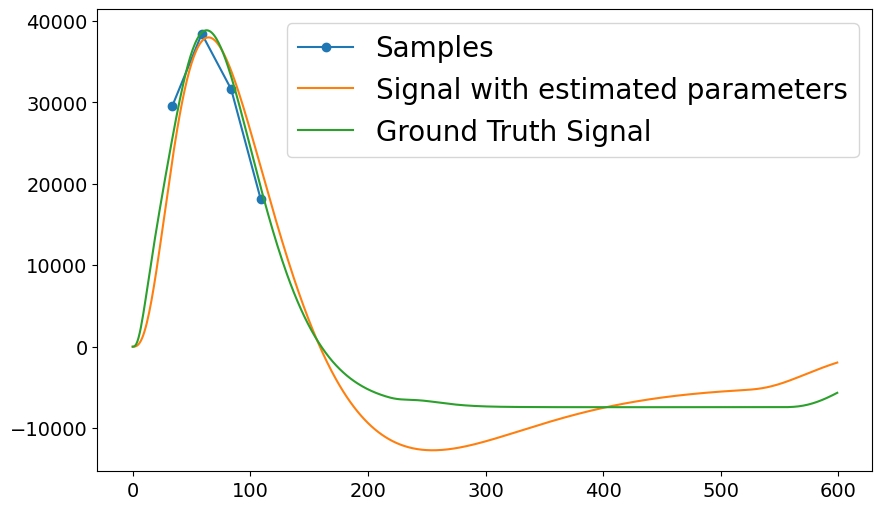

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


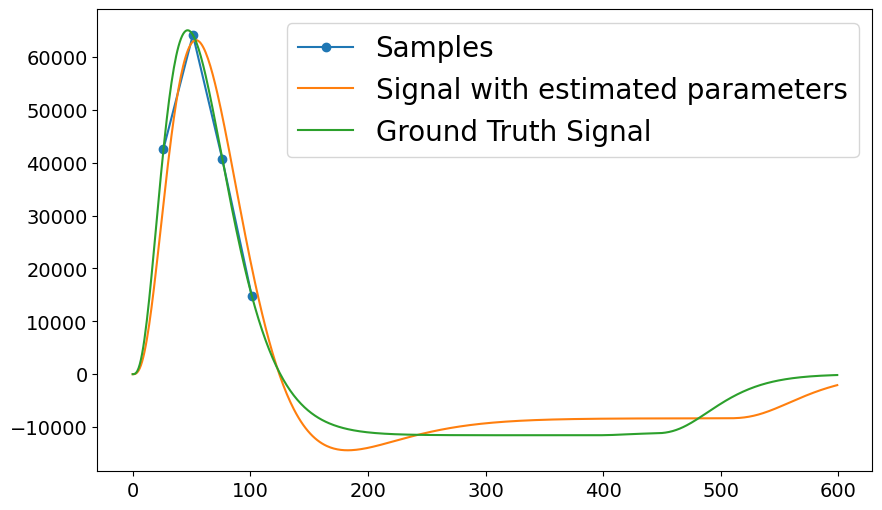

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


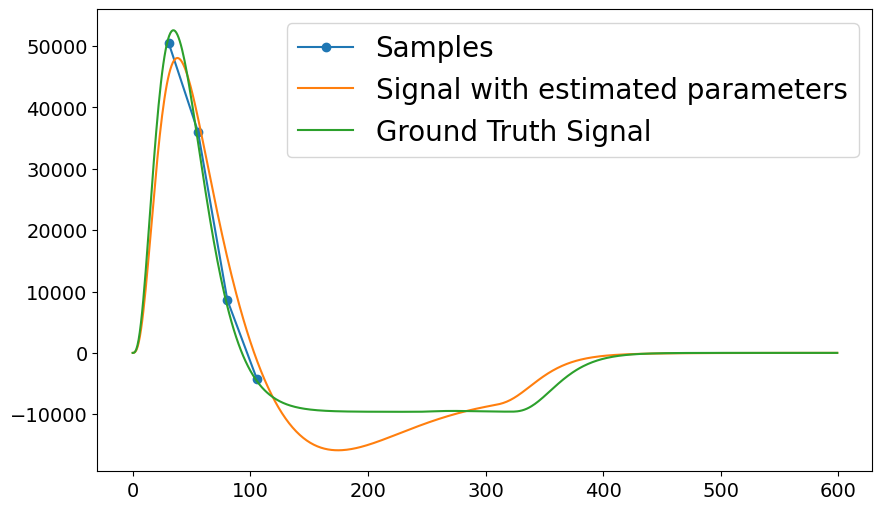

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


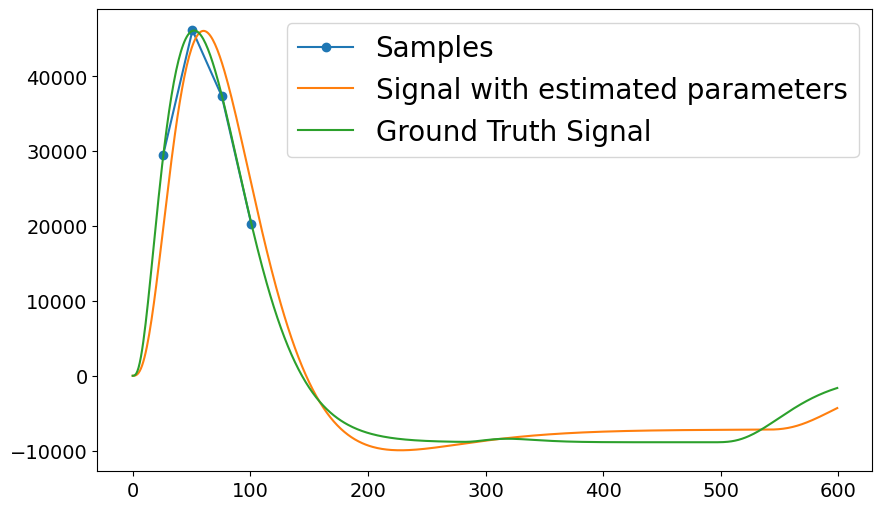

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


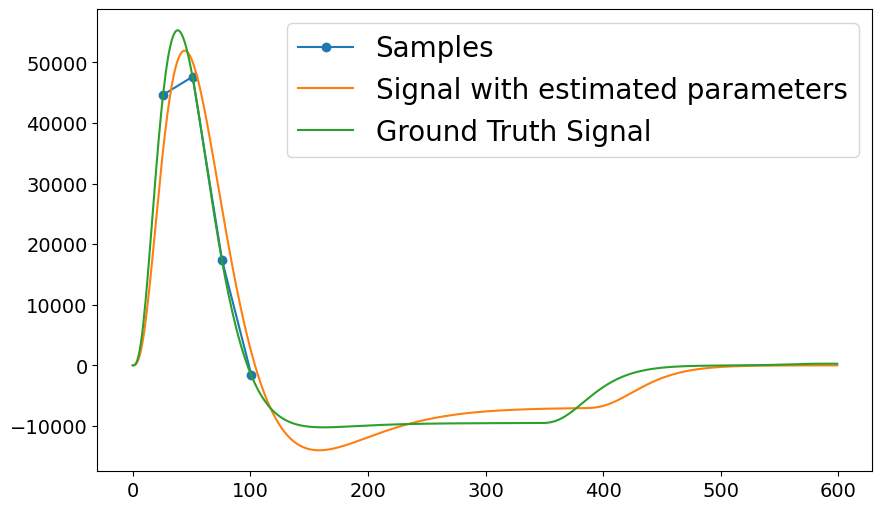

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


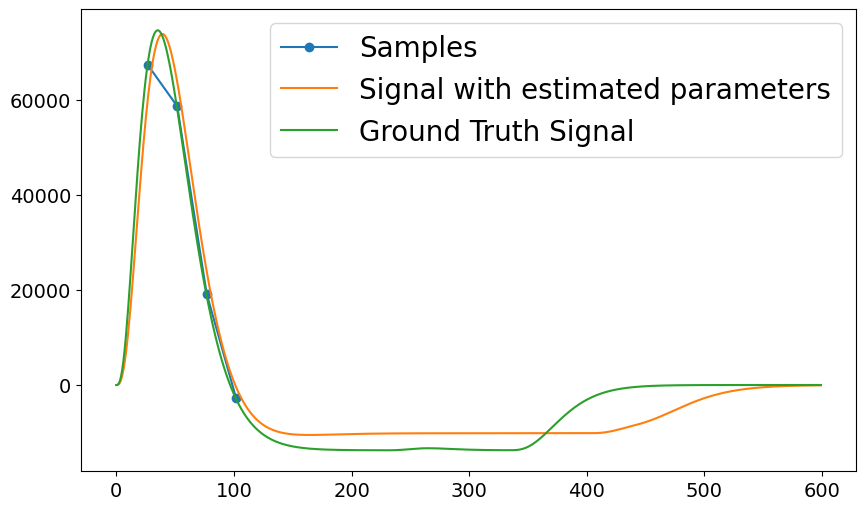

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


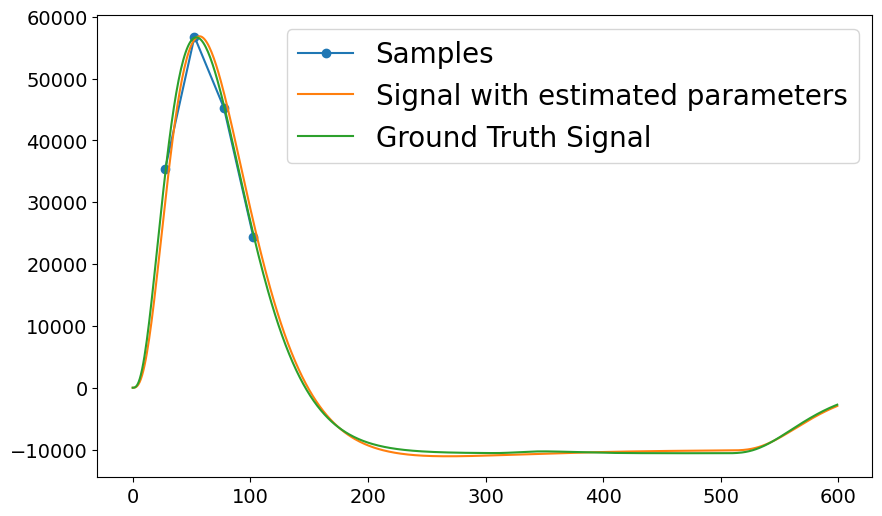

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


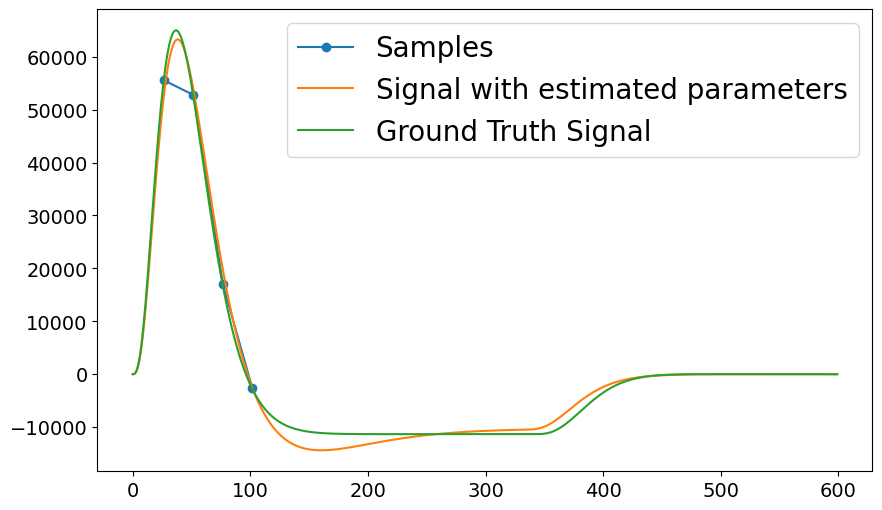

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


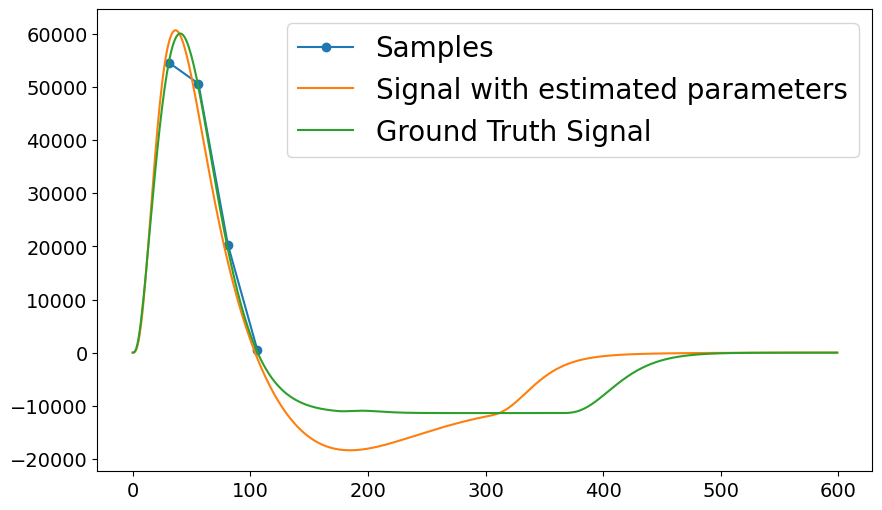

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


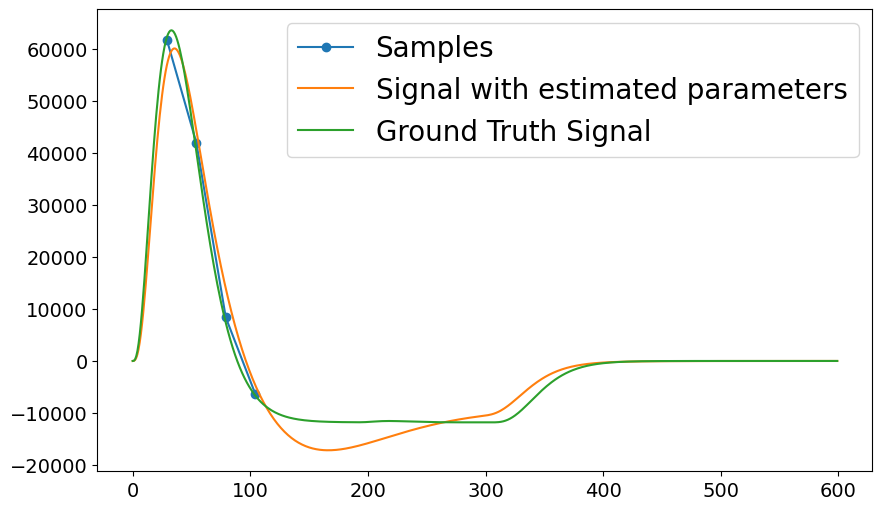

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


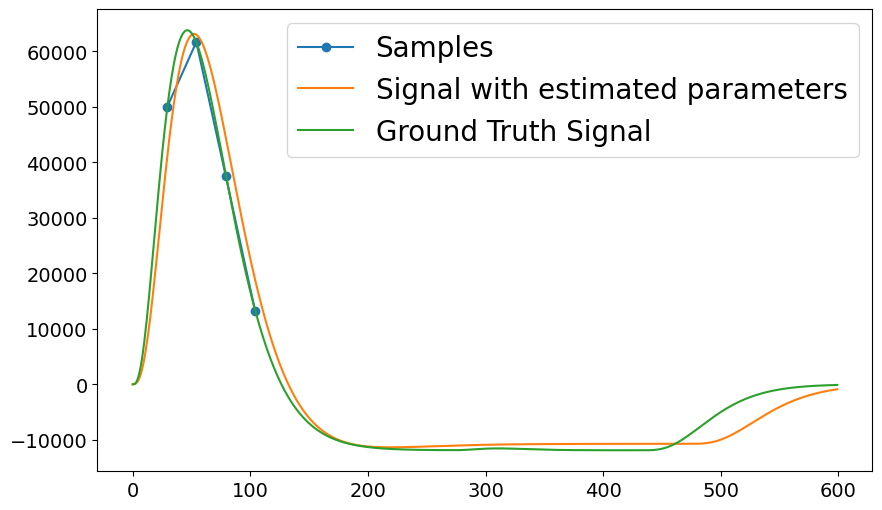

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


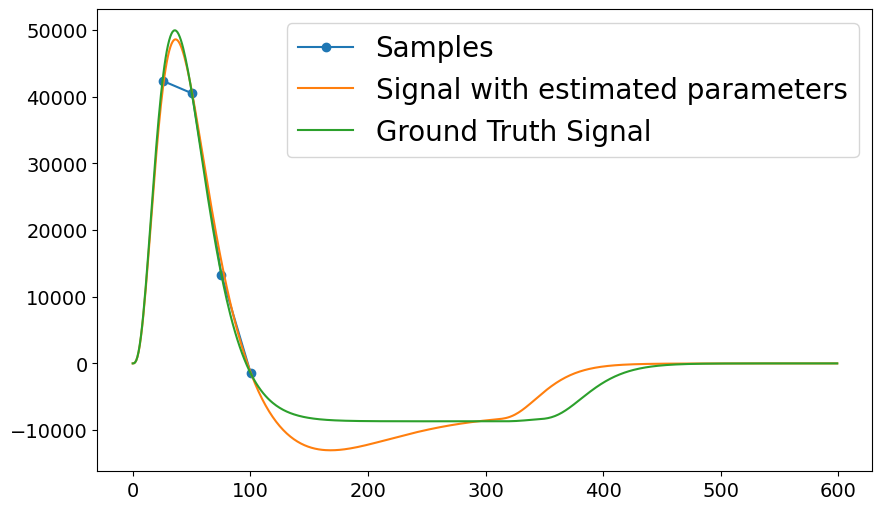

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


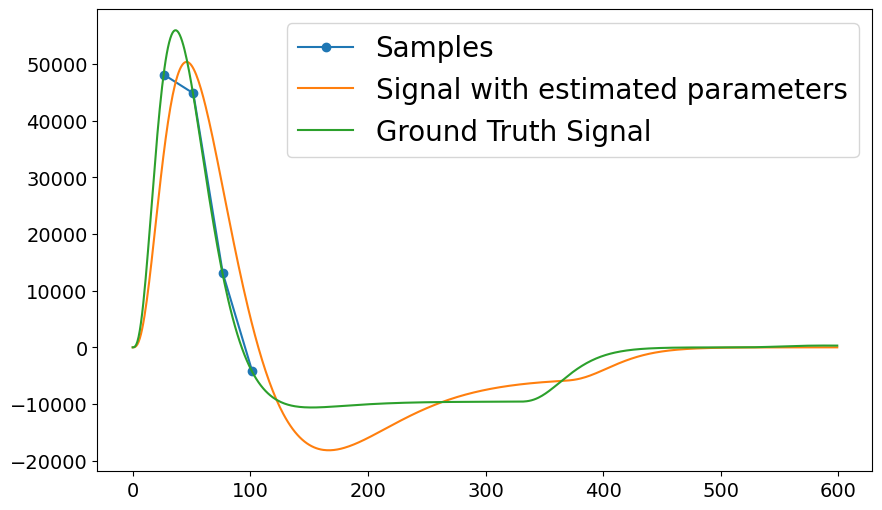

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


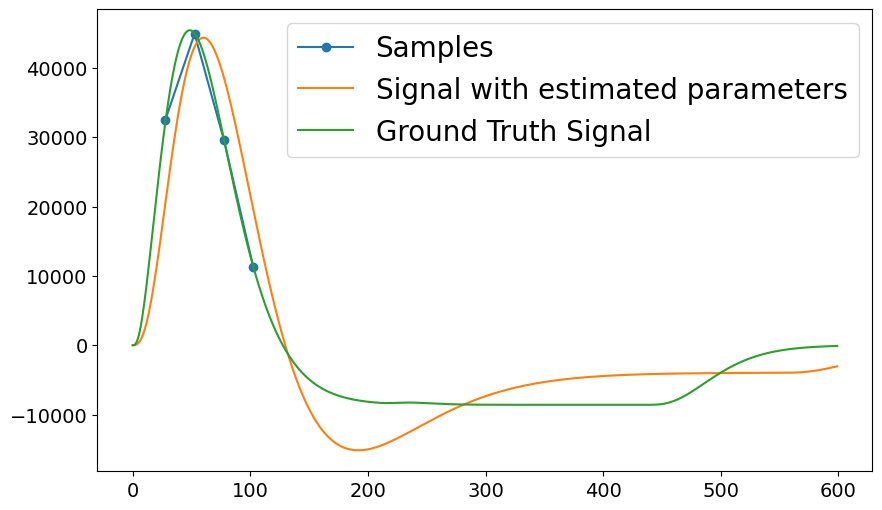

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


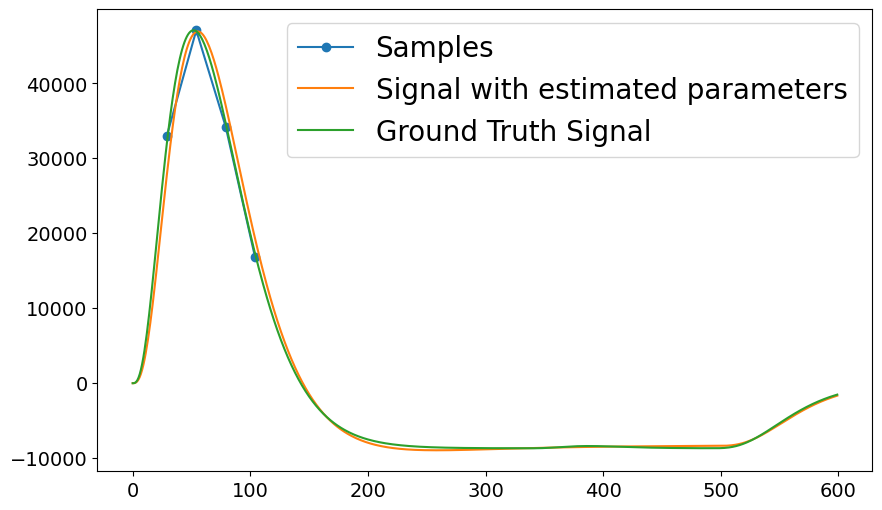

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


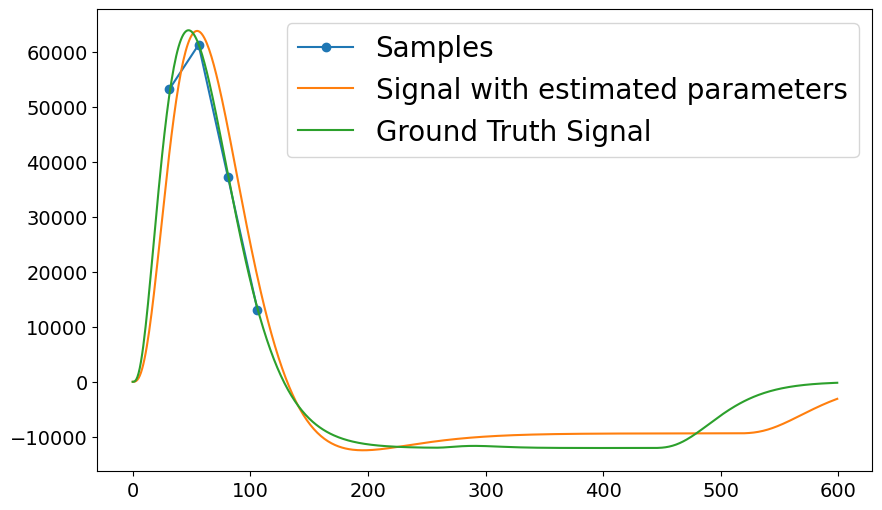

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


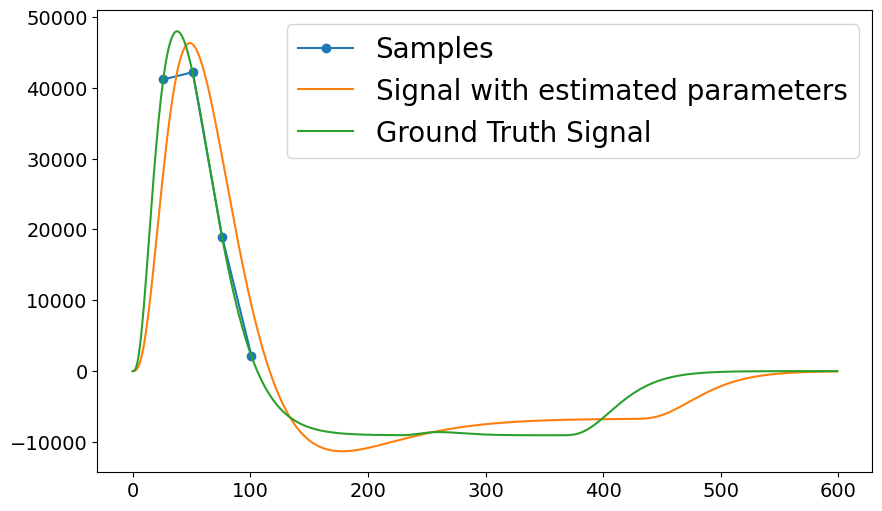

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


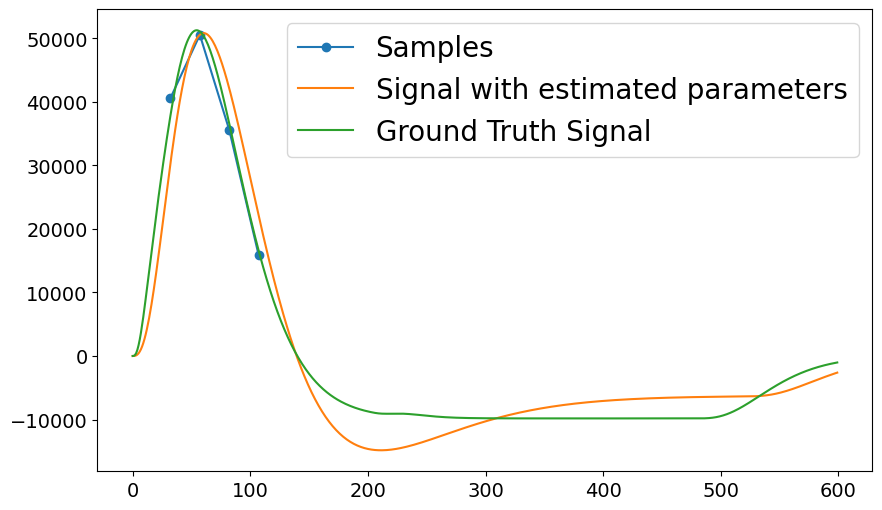

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


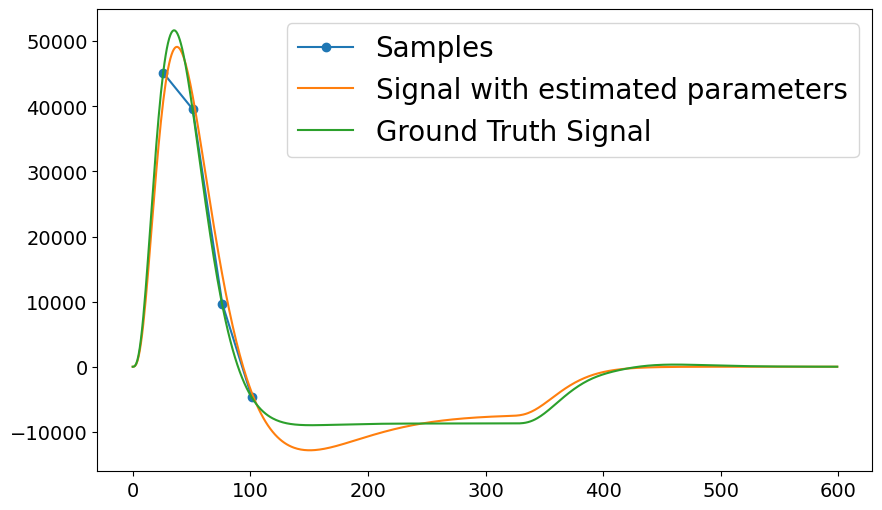

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


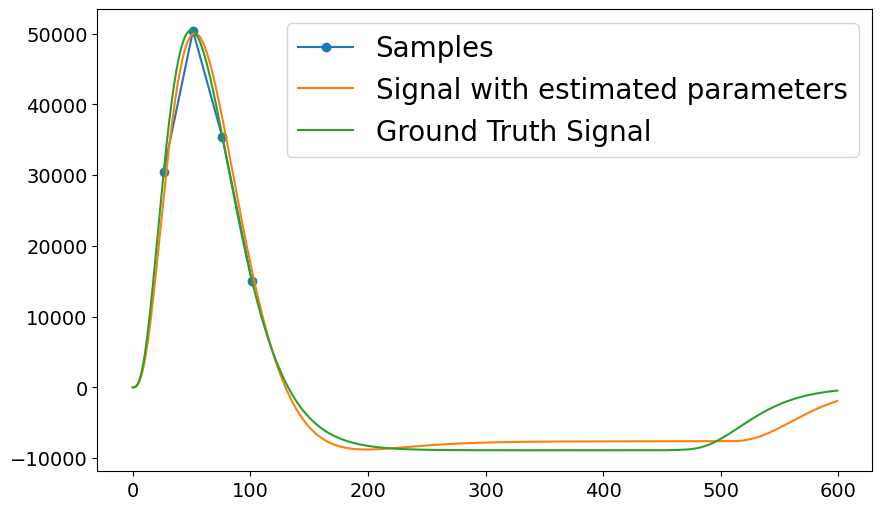

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


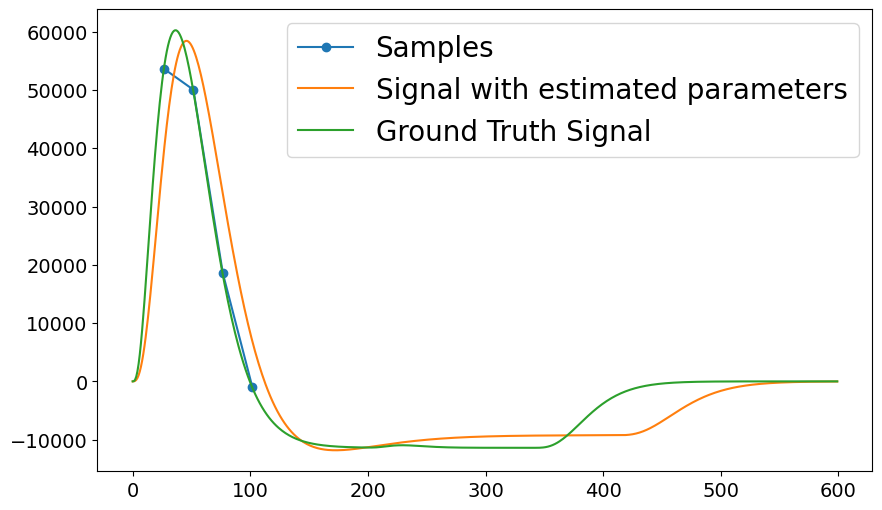

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


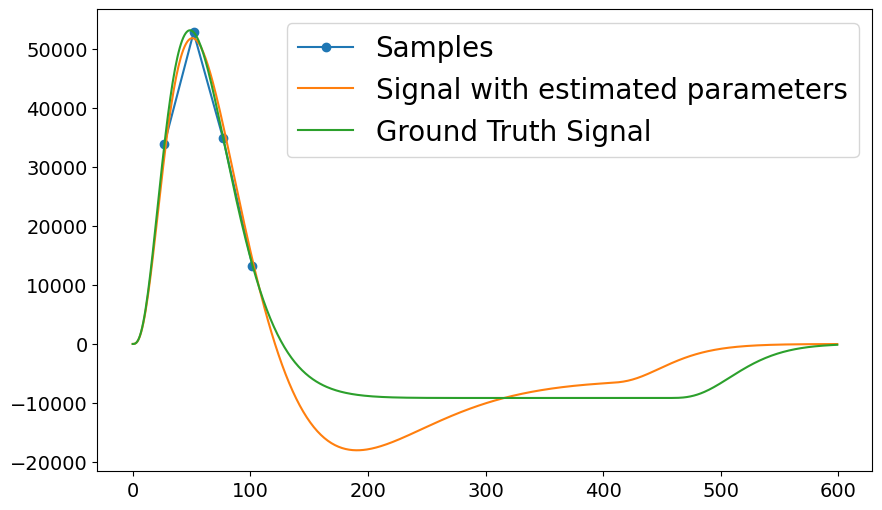

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


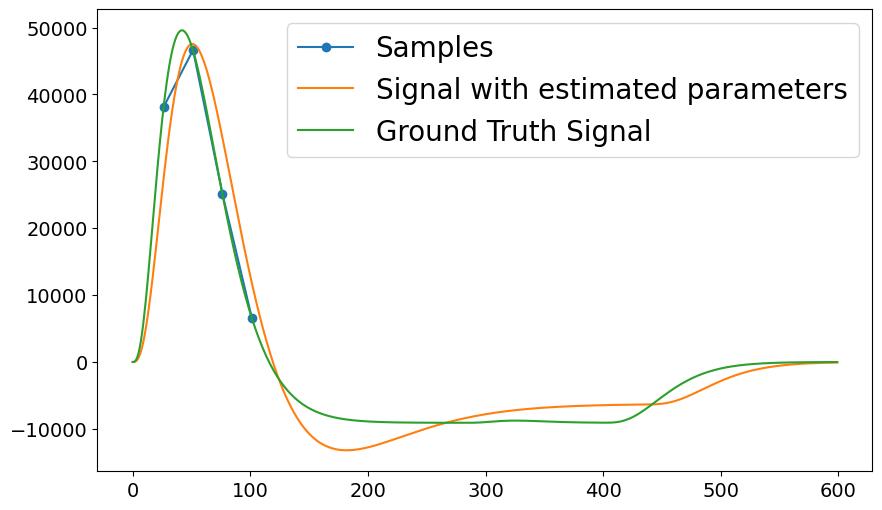

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


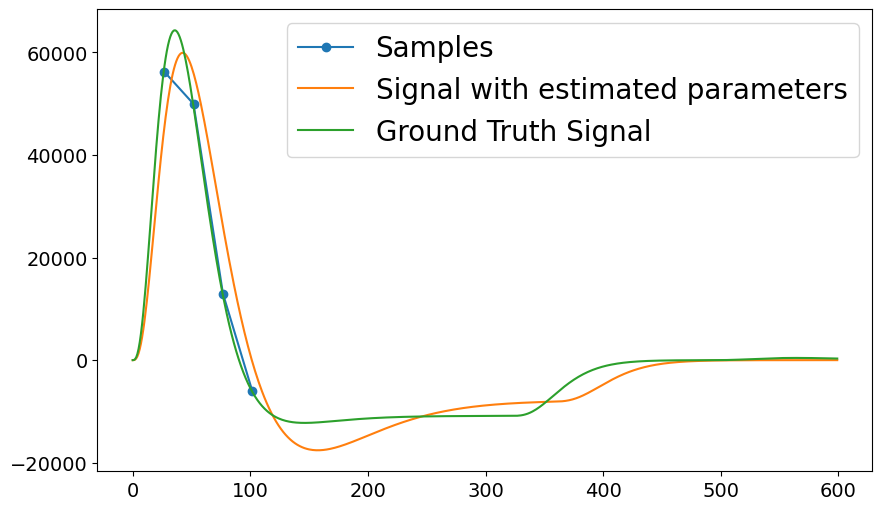

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


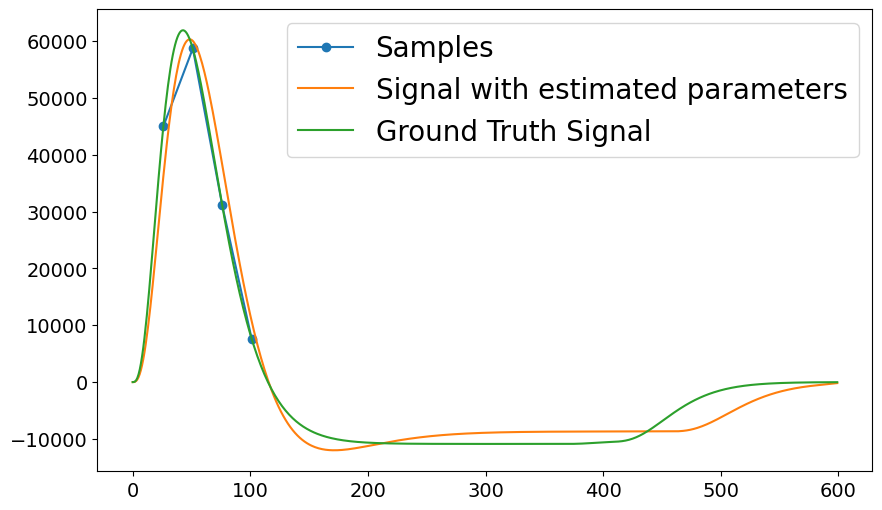

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Leitura do dataset
df = pd.read_csv("./dataset/data.csv", index_col=0)

# Função para aproximar amostra do sinal contaminado por crosstalk
def func_s(params, n, sampling_period=25):
    clean_signal = params["E"] * cellFunction(sampling_period*(n+1)*46.74/params["tau"] + params["sample_delay"])
    xt_signal = params["E_x"] * XTalk(sampling_period*(n+1)*32.16/params["tau_x"] + params["sample_delay"])
    return clean_signal + xt_signal

# Função para calcular o erro quadrático médio (MSE)
def func_mse(samples, params, sampling_period=25):
    mse = 0
    for i in range(samples.shape[0]):
        mse += (samples[i] - func_s(params, i, sampling_period))**2
    mse /= samples.shape[0]
    return mse

# Algoritmo genético para otimizar os parâmetros do sinal
def genetico(samples, funcao=func_mse, sampling_period=25, populacao=100, iteracoes=100, p_recomb=0.15, p_mutacao=0.05):
    E_init = np.abs(np.random.normal(loc=90000, scale=80000, size=populacao))
    tau_init = np.abs(np.random.normal(loc=60, scale=10, size=populacao))
    E_x_init = np.abs(np.random.normal(loc=9000, scale=8000, size=populacao))
    tau_x_init = np.abs(np.random.normal(loc=60, scale=10, size=populacao))
    samp_delay_init = np.abs(np.random.normal(loc=3, scale=4, size=populacao))
    x_matrix = np.stack([E_init, tau_init, E_x_init, tau_x_init, samp_delay_init], axis=1)
    
    avg_fitness = np.array([])
    min_fitness = np.array([])
    col = ['E', 'tau', 'E_x', 'tau_x', 'sample_delay', 'fitness', 'iter']
    df_evolution = pd.DataFrame(columns=col)
    
    x_pop = np.copy(x_matrix)
    time_init = time()
    best = {"E": -np.inf, "tau": -np.inf, "E_x": -np.inf, "tau_x": -np.inf, "sample_delay": -np.inf}
    
    for i in range(iteracoes):
        x_params = [{"E": candidato[0], "tau": candidato[1], "E_x": candidato[2], "tau_x": candidato[3], "sample_delay": candidato[4]} for candidato in x_pop]
        x_fitness = np.array([-funcao(samples, params, sampling_period) for params in x_params]).reshape(-1, 1)
        iter_atual = np.tile([i], x_pop.shape[0]).reshape(-1, 1)
        df_data = np.concatenate((x_pop, x_fitness, iter_atual), axis=1)
        df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)
        
        avg_fitness = np.append(avg_fitness, np.mean(x_fitness))
        min_fitness = np.append(min_fitness, np.min(x_fitness))
        
        x_sort = np.argsort(x_fitness, axis=0).reshape(-1)
        x_fitness = x_fitness[x_sort]
        x_pop = x_pop[x_sort]
        best = {"E": x_pop[-1, 0], "tau": x_pop[-1, 1], "E_x": x_pop[-1, 2], "tau_x": x_pop[-1, 3], "sample_delay": x_pop[-1, 4]}
        
        prob_num = np.array([np.sum(np.arange(1, i+1)) for i in range(1, x_pop.shape[0]+1)])
        prob_den = np.sum(np.arange(1, x_pop.shape[0]+1))
        prob = prob_num / prob_den
        
        selecao_prob = np.random.rand(np.ceil(x_pop.shape[0]/2).astype(np.int32), 2)
        index_selecao_prob = np.searchsorted(prob, selecao_prob, side='right')
        
        new_pop = np.empty((0, x_pop.shape[1]))
        for j in index_selecao_prob:
            candidato1 = x_pop[j[0]]
            candidato2 = x_pop[j[1]]
            recomb_mask = np.random.rand(candidato1.shape[0]) <= p_recomb
            novo_candidato1 = np.where(recomb_mask, candidato2, candidato1).reshape((1, -1))
            novo_candidato2 = np.where(recomb_mask, candidato1, candidato2).reshape((1, -1))
            new_pop = np.concatenate((new_pop, novo_candidato1, novo_candidato2), axis=0)
        new_pop = new_pop[:x_pop.shape[0]]
        
        E_init = np.abs(np.random.normal(loc=90000, scale=80000, size=populacao))
        tau_init = np.abs(np.random.normal(loc=60, scale=10, size=populacao))
        E_x_init = np.abs(np.random.normal(loc=9000, scale=8000, size=populacao))
        tau_x_init = np.abs(np.random.normal(loc=60, scale=10, size=populacao))
        samp_delay_init = np.abs(np.random.normal(loc=3, scale=4, size=populacao))
        mut_gen = np.stack([E_init, tau_init, E_x_init, tau_x_init, samp_delay_init], axis=1)
        mut_mask = np.random.rand(new_pop.shape[0], new_pop.shape[1]) <= p_mutacao
        new_pop = np.where(mut_mask, mut_gen, new_pop)
        
        x_pop = np.copy(new_pop)
        
        if i == iteracoes - 1:
            x_params = [{"E": candidato[0], "tau": candidato[1], "E_x": candidato[2], "tau_x": candidato[3], "sample_delay": candidato[4]} for candidato in x_pop]
            x_fitness = np.array([-funcao(samples, params, sampling_period) for params in x_params]).reshape(-1, 1)
            iter_atual = np.tile([i], x_pop.shape[0]).reshape(-1, 1)
            df_data = np.concatenate((x_pop, x_fitness, iter_atual), axis=1)
            df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)
            avg_fitness = np.append(avg_fitness, np.mean(x_fitness))
            min_fitness = np.append(min_fitness, np.min(x_fitness))
    
    elapsed_time = (time() - time_init) * 1000
    fitness_metrics = np.concatenate((avg_fitness.reshape(-1,1), min_fitness.reshape(-1,1)), axis=1)
    df_fitness = pd.DataFrame(fitness_metrics, columns=["avg_fitness", "min_fitness"])
    
    return best, df_evolution, df_fitness, elapsed_time

# Processar todos os sinais e gerar gráficos comparativos
for signal_index in range(100):
    samples = np.array([df[f"S_{i}"][signal_index] for i in range(1, 5)])
    best, df_evolution, df_fitness, elapsed_time = genetico(samples)
    
    df_est_comparison = pd.DataFrame(data=[["E", best["E"], df["E"][signal_index]],
                                           ["Tau", best["tau"], df["tau"][signal_index]],
                                           ["E_x", best["E_x"], df["E_x"][signal_index]],
                                           ["Tau_x", best["tau_x"], df["tau_x"][signal_index]],
                                           ["Sampling Delay", best["sample_delay"], df["delay_sampling"][signal_index]]],
                                     columns=["Parâmetro", "Estimado", "Esperado"])
    
    plt.plot([df["delay_sampling"][signal_index] + 25, df["delay_sampling"][signal_index] + 50, df["delay_sampling"][signal_index] + 75, df["delay_sampling"][signal_index] + 100], samples, marker='o', label="Samples")

    ETrue_est = np.array([best["E"]*cellFunction(t*46.74/best["tau"]) for t in range(600)])
    XT_est = np.array([best["E_x"]*XTalk(t*32.16/best["tau_x"]) for t in range(600)])
    signal_est = ETrue_est + XT_est

    ETrue_gt = np.array([df["E"][signal_index]*cellFunction(t*46.74/df["tau"][signal_index]) for t in range(600)])
    XT_gt = np.array([df["E_x"][signal_index]*XTalk(t*32.16/df["tau_x"][signal_index]) for t in range(600)])
    signal_gt = ETrue_gt + XT_gt

    # Gráfico Comparativo
    plt.plot(range(600), signal_est, label="Signal with estimated parameters")
    plt.plot(range(600), signal_gt, label="Ground Truth Signal")
    plt.legend()
    plt.show()

In [22]:
# Gerar tabelas df_est_comparison para todos os sinais
df_comparison_list = []
for signal_index in range(100):
    samples = np.array([df[f"S_{i}"][signal_index] for i in range(1, 5)])
    best, df_evolution, df_fitness, elapsed_time = genetico(samples)
    
    df_est_comparison = pd.DataFrame(data=[["E", best["E"], df["E"][signal_index]],
                                           ["Tau", best["tau"], df["tau"][signal_index]],
                                           ["E_x", best["E_x"], df["E_x"][signal_index]],
                                           ["Tau_x", best["tau_x"], df["tau_x"][signal_index]],
                                           ["Sampling Delay", best["sample_delay"], df["delay_sampling"][signal_index]]],
                                     columns=["Parâmetro", "Estimado", "Esperado"])
    
    df_comparison_list.append(df_est_comparison)

# Exibir as tabelas geradas
for index, df_comparison in enumerate(df_comparison_list):
    print(f"Tabela de Comparação para o Sinal {index + 1}")
    print(df_comparison)
    print("\n")

C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)
C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)
C:\Users\victo\AppData\Local\Temp\ipykernel_8332\3763812524.py:46: FutureWarning: 

Tabela de Comparação para o Sinal 1
        Parâmetro      Estimado      Esperado
0               E  53755.276744  59412.274869
1             Tau     61.137944     56.080000
2             E_x   5260.392814   4792.422617
3           Tau_x     40.266558     17.280000
4  Sampling Delay      5.321545      3.271603


Tabela de Comparação para o Sinal 2
        Parâmetro      Estimado      Esperado
0               E  35719.528182  51691.298481
1             Tau     51.233991     40.860000
2             E_x  15964.672773   4170.764452
3           Tau_x     41.844401     23.260000
4  Sampling Delay      7.407910      0.838006


Tabela de Comparação para o Sinal 3
        Parâmetro      Estimado      Esperado
0               E  61934.527181  79307.711870
1             Tau     41.677341     34.450000
2             E_x  13633.853560   2246.259140
3           Tau_x     43.649214     20.140000
4  Sampling Delay     10.498910      0.570604


Tabela de Comparação para o Sinal 4
        Parâmetro     